In [1]:
%load_ext autoreload
%autoreload 2

import os,sys,warnings
import h5py, pandas
import numpy as np
np.seterr(invalid=['ignore','warn'][0])
np.set_printoptions(legacy='1.25')
import math,cmath,pickle
from matplotlib.backends.backend_pdf import PdfPages
from scipy.optimize import curve_fit
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('default')
mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['figure.titlesize'] = 20
mpl.rcParams['figure.figsize'] = [6.4*1.2,4.8*1.2]
mpl.rcParams['axes.labelsize'] = 30
mpl.rcParams['axes.titlesize'] = 30
mpl.rcParams['lines.marker'] = 's'
mpl.rcParams['lines.linestyle'] = ''
mpl.rcParams['lines.markersize'] = 8
mpl.rcParams['errorbar.capsize'] = 12
mpl.rcParams['xtick.labelsize'] = mpl.rcParams['ytick.labelsize'] = 22
mpl.rcParams['xtick.major.size'] = mpl.rcParams['ytick.major.size'] = 10
mpl.rcParams['xtick.top']=mpl.rcParams['ytick.right']=True
mpl.rcParams['xtick.direction']=mpl.rcParams['ytick.direction']='in'
mpl.rcParams['legend.fontsize'] = 24
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"

# mpl.rcParams.update({"axes.grid" : True})
import util as yu
yu.flag_fast=False

enss=['b']
ens2full={'a24':'cA211.53.24','a':'cA2.09.48','b':'B64','c':'C80','d':'D96'}
ens2label={'a24':'A24','a':'A48','b':'B64','c':'C80','d':'D96'}
ens2a={'a24':0.0908,'a':0.0938,'b':0.07957,'c':0.06821,'d':0.05692} # fm
ens2N={'a24':24,'a':48,'b':64,'c':80,'d':96}
ens2N_T={'a24':24*2,'a':48*2,'b':64*2,'c':80*2,'d':96*2}

# ens2mN={'a':931}
# ens2mpiC={'a':131}
# ens2mpi0={'a':111}

ens2amu={'a24':0.0053,'a':0.0009,'b':0.00072}
ens2ZP={'a24':(0.4670,0.0046),'a':(0.500,0.030)}

hbarc = 1/197.3
ens2aInv={ens:1/(ens2a[ens]*hbarc) for ens in enss} # MeV

ens='b'

In [2]:
Tpack=32; d_jk=1
path='/capstor/store/cscs/userlab/s1174/lyan/code/projectData2/01_Nsgm/cB211.072.64_base/data_merge/Nsgm_4src_16,18,20.h5'
data=yu.load(path,d=d_jk)
Ncfg,Njk=data['cfgs'][1:]
print(f'Ncfg={Ncfg},Njk={Njk}')

cfg2old=lambda cfg: cfg[1:]+'_r'+{'a':'0','b':'1','c':'2','d':'3'}[cfg[0]]
cfg2new=lambda cfg: {'0':'a','1':'b','2':'c','3':'d'}[cfg[-1]] + cfg[:4]

tfs=[8,10,12,14,16,18,20]
path='/capstor/store/cscs/userlab/s1174/lyan/code/projectData2/01_Nsgm/cB211.072.64_base/data_from_others/thrp-conn.h5'
with h5py.File(path) as f:
    # cfgs_NJN=[cfg2new(cfg) for cfg in f['gS/up/dt10'].keys()]
    cfgs_old=[cfg2old(cfg) for cfg in data['cfgs'][0]]

    c3ptDic_NJN={tf:np.real(yu.jackknife([f[f'gS/up/dt{tf}/{cfg}'][:] + f[f'gS/dn/dt{tf}/{cfg}'][:] for cfg in cfgs_old],d=d_jk)) for tf in tfs}
    c2ptCorrDic_NJN={tf:np.real(yu.jackknife([f[f'dt{tf}_twop/{cfg}'][()] for cfg in cfgs_old],d=d_jk)) for tf in tfs}

loading: /capstor/store/cscs/userlab/s1174/lyan/code/projectData2/01_Nsgm/cB211.072.64_base/data_merge/Nsgm_4src_16,18,20.h5
482/482: diags/Z3pt/srcs/Z3pt.h5_NJNpi-Nsrc=4*1                               
Ncfg=732,Njk=732


In [3]:
flags={
    'cc2pt':True, # average quantities related by complex conjugation for 2pt
    'cc3pt':True, # same for 3pt (Removal of vacuum expectation value requires 'cc2pt'=='cc3pt')
    'll2pt':True, # average irrep rows 'l1' and conjugated 'l2' (Parity breaking effect of tmQCD has been taken care of)
    'll3pt':True, # same for 3pt (This flag has no effect if 'll2pt'=True and spin-projection is done)
    'r2pt': True, # making 2ptMat real for the rest frame # 'll2pt' has to be real for this flag
    'remove_pi0VEV':True, 
    'remove_jVEV':True,
}

def op_remove_pi0(op):
    t=op.split(';')
    if t[-1] in ['p','n','n,pi+']:
        return False
    if t[3] not in ['N0pi0,a','N1pi0,a','N0sgm0,a','N1sgm0,a']:
        return False
    if t[3] in ['N0sgm0,a','N1sgm0,a']:
        t[3]='a'
        t[-1]={'p,sgm':'p'}[t[-1]]
        return ';'.join(t)
    if t[2] == 'G1u':
        t[2]='G1g'
        assert(t[3]=='N0pi0,a'); t[3]='a'
        assert(t[-1]=='p,pi0'); t[-1]='p'
        return ';'.join(t)

def get2pt_diag(opa,opb,diag):
    opab=f'{opa}_{opb}'
    if opab not in data['2pt'].keys() or diag not in data['2pt'][opab].keys():
        return 0
    res=data['2pt'][opab][diag].copy()
    if not flags['remove_pi0VEV']:
        return res
    if diag == 'pi0f-pi0i':
        if opa==opb and opa=='t;0,0,0;pi0':
            res -= (data['VEV']['pi0f']**2)[:,None]
        return res
    
    if 'pi0f' in diag.split('-'):
        t_opa=op_remove_pi0(opa)
        if t_opa != False:
            t=diag.split('-'); t.remove('pi0f'); t_diag='-'.join(t)
            res -= data['2pt'][f'{t_opa}_{opb}'][t_diag] * data['VEV']['pi0f'][opa.split(';')[-1].split(',')[-1]][:,None]
    if 'pi0i' in diag.split('-'):
        t_opb=op_remove_pi0(opb)
        if t_opb != False:
            t=diag.split('-'); t.remove('pi0i'); t_diag='-'.join(t)
            res -= data['2pt'][f'{opa}_{t_opb}'][t_diag] * np.conj(data['VEV']['pi0f'][opb.split(';')[-1].split(',')[-1]][:,None])
    if 'pi0f' in diag.split('-') and 'pi0i' in diag.split('-'):
        t_opa=op_remove_pi0(opa); t_opb=op_remove_pi0(opb)
        if t_opa != False and t_opb != False:
            t=diag.split('-'); t.remove('pi0f'); t.remove('pi0i'); t_diag='-'.join(t)
            res += data['2pt'][f'{t_opa}_{t_opb}'][t_diag] * data['VEV']['pi0f'][opa.split(';')[-1].split(',')[-1]][:,None] * np.conj(data['VEV']['pi0f'][opb.split(';')[-1].split(',')[-1]][:,None])
    return res

def get2pt(opa,opb,diags=yu.diags_all):
    res=np.zeros([Njk,Tpack],dtype=complex)
    opab=f'{opa}_{opb}'; opba=f'{opb}_{opa}'
    if opab in data['2pt']:
        res+=np.sum([get2pt_diag(opa,opb,diag) for diag in data['2pt'][opab].keys() if diag in diags],axis=0)
    if opba in data['2pt']:
        diags_cc={'T', 'T-pi0f'}; 
        res+=np.conj(np.sum([get2pt_diag(opa,opb,diag) for diag in data['2pt'][opba].keys() if diag in diags_cc and diag in diags],axis=0))
    return res

def get2ptMat(ops,diags=yu.diags_all):
    if flags['ll2pt']:
        flags['ll2pt']=False
        ops_flip=[yu.op_flipl(op) for op in ops]
        t=(get2ptMat(ops,diags=diags)+np.conj(get2ptMat(ops_flip,diags=diags)))/2
        flags['ll2pt']=True
        if ops[0].split(';')[1]=='0,0,0' and flags['r2pt']:
            t=np.real(t)
        return t
    t=np.transpose([[get2pt(opa,opb,diags) for opb in ops] for opa in ops],[2,3,0,1])
    if flags['cc2pt']:
        t=(t+np.conj(np.transpose(t,[0,1,3,2])))/2
    return t

tfs=[8,10,12,14,16,18,20]

def get3pt_diag(opa,opb,insert,diag):
    if opa in ['g;0,0,0;G1g;a;l1;p','g;0,0,0;G1g;a;l2;p'] and opb in ['g;0,0,0;G1g;a;l1;p','g;0,0,0;G1g;a;l2;p'] and insert.startswith('id_j+_') and diag=='NJN':
        gm,j,tf=insert.split('_')
        res=c3ptDic_NJN[int(tf)]
        return res
    
    opab=f'{opa}_{opb}'
    if opab not in data['3pt'].keys() or diag not in data['3pt'][opab][insert].keys():
        return 0
    res=data['3pt'][opab][insert][diag].copy()
    if flags['remove_pi0VEV']:
        if 'pi0f' in diag.split('-'):
            t_opa=op_remove_pi0(opa)
            if t_opa != False:
                t=diag.split('-'); t.remove('pi0f'); t_diag='-'.join(t)
                res -= data['3pt'][f'{t_opa}_{opb}'][insert][t_diag] * data['VEV']['pi0f'][opa.split(';')[-1].split(',')[-1]][:,None]
        if 'pi0i' in diag.split('-'):
            t_opb=op_remove_pi0(opb)
            if t_opb != False:
                t=diag.split('-'); t.remove('pi0i'); t_diag='-'.join(t)
                res -= data['3pt'][f'{opa}_{t_opb}'][insert][t_diag] * np.conj(data['VEV']['pi0f'][opb.split(';')[-1].split(',')[-1]][:,None])
        if 'pi0f' in diag.split('-') and 'pi0i' in diag.split('-'):
            t_opa=op_remove_pi0(opa); t_opb=op_remove_pi0(opb)
            if t_opa != False and t_opb != False:
                t=diag.split('-'); t.remove('pi0f'); t.remove('pi0i'); t_diag='-'.join(t)
                res += data['3pt'][f'{t_opa}_{t_opb}'][insert][t_diag] * data['VEV']['pi0f'][opa.split(';')[-1].split(',')[-1]][:,None] * np.conj(data['VEV']['pi0f'][opb.split(';')[-1].split(',')[-1]][:,None])
    if flags['remove_jVEV']:
        gm,j,tf=insert.split('_')
        t_insert='_'.join([gm,j])
        if 'j' in diag.split('-') and t_insert in ['id_j+','id_js','id_jc','g5_j-']:
            t=diag.split('-'); t.remove('j'); t_diag='-'.join(t)
            res -= (get2pt_diag(opa,opb,t_diag)[:,int(tf)] * data['VEV']['j'][t_insert])[:,None]
    return res

def get3pt(opa,opb,insert,diags=yu.diags_all):
    res=np.zeros([Njk,int(insert.split('_')[-1])+1],dtype=complex)
    opab=f'{opa}_{opb}'; opba=f'{opb}_{opa}'
    if opab in data['3pt']:
        res+=np.sum([get3pt_diag(opa,opb,insert,diag) for diag in data['3pt'][opab][insert].keys() if diag in diags],axis=0)
    if opba in data['3pt']:
        t=data['3pt'][opb+'_'+opa][insert]; 
        diags_cc={'B3pt','W3pt','Z3pt','T-j', 'T-pi0f-j','T-jPf','B3pt-pi0f','W3pt-pi0f','Z3pt-pi0f'}; 
        if opab not in data['3pt'] or 'NJN-pi0f' not in data['3pt'][opab][insert]:
            diags_cc.add('NJN-pi0i')
        t_add=np.zeros([Njk,int(insert.split('_')[-1])+1],dtype=complex)+np.sum([get3pt_diag(opb,opa,insert,diag) for diag in t.keys() if diag in diags_cc and diag in diags],axis=0)
        res+=np.conj(t_add[:,::-1])*(yu.gtCj[insert.split('_')[0]])
    return res

def get3ptMat(opas,opbs,insert,diags=yu.diags_all):
    if flags['ll3pt']:
        flags['ll3pt']=False
        opas_flip=[yu.op_flipl(op) for op in opas]; opbs_flip=[yu.op_flipl(op) for op in opbs]
        sgns=np.array([[yu.op_getl_sgn(opa)*yu.op_getl_sgn(opb) for opb in opbs] for opa in opas])
        sgns*=yu.fourCPTstar[insert.split('_')[0]]
        t=(get3ptMat(opas,opbs,insert,diags=diags)+np.conj(get3ptMat(opas_flip,opbs_flip,insert,diags=diags))*sgns[None,None,:,:])/2
        flags['ll3pt']=True
        return t
    t=np.transpose([[get3pt(opa,opb,insert,diags) for opb in opbs] for opa in opas],[2,3,0,1])
    if flags['cc3pt']:
        flags['cc3pt']=False
        tt=get3ptMat(opbs,opas,insert,diags)[:,::-1]*(yu.gtCj[insert.split('_')[0]])
        flags['cc3pt']=True
        t=(t+np.conj(np.transpose(tt,[0,1,3,2])))/2
    return t

In [4]:
ops=['g;0,0,0;G1g;a;l1;p','g;0,0,0;G1g;N0sgm0,a;l1;p,sgm']
j='j+'; tfs=[8,10,12,14,16,18,20]

c2ptM=get2ptMat(ops)
c3ptM_dic={tf:get3ptMat(ops,ops,f'id_{j}_{tf}',diags=yu.diags_all) for tf in tfs}

GEVP_t0,GEVP_t=7,14
evals,evecs=yu.GEVP(np.mean(c2ptM,axis=0),GEVP_t0)
Revec=evecs[GEVP_t,0,1]/evecs[GEVP_t,0,0]

lbd=1.0
x=Revec*lbd
c2pt=np.real(c2ptM[:,:,0,0] + x*c2ptM[:,:,0,1] + x*c2ptM[:,:,1,0] + x**2*c2ptM[:,:,1,1] *0)
c3ptDic={tf:np.real(c3ptM_dic[tf][:,:,0,0]+x*c3ptM_dic[tf][:,:,0,1] + x*c3ptM_dic[tf][:,:,1,0]) for tf in tfs}
c3ptDic_0={tf:np.real(c3ptM_dic[tf][:,:,0,0]) for tf in tfs}
c3ptDic_x={tf:np.real(x*c3ptM_dic[tf][:,:,0,1] + x*c3ptM_dic[tf][:,:,1,0]) for tf in tfs}
c2ptCorrDic={tf:np.real(c2ptCorrDic_NJN[tf] + x*c2ptM[:,tf,0,1] + x*c2ptM[:,tf,1,0]) for tf in tfs}

ratioCorr={tf:c3ptDic[tf][:,:]/c2ptCorrDic[tf][:,None] for tf in tfs}
ratioCorr_0={tf:c3ptDic_0[tf][:,:]/c2ptCorrDic[tf][:,None] for tf in tfs}
ratioCorr_x={tf:c3ptDic_x[tf][:,:]/c2ptCorrDic[tf][:,None] for tf in tfs}

stats={8:1,10:1,12:1,14:4,16:4,18:4,20:4}
for tf in tfs:
    mean,err=yu.jackme(ratioCorr[tf][:,tf//2])
    meanx,errx=yu.jackme(ratioCorr_x[tf][:,tf//2])
    mean0,err0=yu.jackme(ratioCorr_0[tf][:,tf//2])
    
    print(tf,np.sqrt(errx**2+err0**2)/err,errx/err,err0/err)
    print(err,np.sqrt(err0**2+errx**2),np.sqrt(err0**2+errx**2/stats[tf]))
    print()

8 1.346148504237763 0.7592668040467191 1.1115888249412404
0.37470888503181465 0.5044138051101772 0.5044138051101772

10 1.2416069333091968 0.7122412567267896 1.0170054911639916
0.3493360873311338 0.43373810808544283 0.43373810808544283

12 1.1773360901662975 0.7292143619304744 0.9243195786968893
0.40366587432189477 0.4752504022076996 0.4752504022076996

14 1.0770026031205175 0.7327941637349155 0.7892701189861536
0.5073654951818564 0.5464339590443897 0.4414937412509847

16 1.0922329632492487 0.7031404346111119 0.8358028327441417
0.5716312343605129 0.6243544769914088 0.5183179315079811

18 1.0345701105259295 0.8227147166289674 0.6272765009433653
0.7506488709227241 0.7765988853566869 0.5630820700304543

20 0.989483652135827 0.847603371975663 0.5105354264490762
1.2191987824892094 1.2063772639769768 0.8089586421176725



In [8]:
# summation method

settings={
    'tfmins':[8,10,12,14,16],
    'tcmins':[1],
    
    'ylim':[0,80],
}

chi2Size=9
colorDic={8:'pink',10:'orange',12:'lightgreen',14:'purple',16:'skyblue',18:'brown',20:'blue'}
fmtDic={4:'v',5:'d',6:'o',7:'s',8:'<',9:'>',10:'^'}

colorDic={1:'r',2:'g',3:'b'}

ops=['g;0,0,0;G1g;a;l1;p','g;0,0,0;G1g;N0sgm0,a;l1;p,sgm']
j='j+'; tfs=[8,10,12,14,16,18,20]

c2ptM=get2ptMat(ops)
c3ptM_dic={tf:get3ptMat(ops,ops,f'id_{j}_{tf}',diags=yu.diags_all) for tf in tfs}

GEVP_t0,GEVP_t=7,14
evals,evecs=yu.GEVP(np.mean(c2ptM,axis=0),GEVP_t0)
Revec=evecs[GEVP_t,0,1]/evecs[GEVP_t,0,0]


func_C2pt_1st=lambda t,E0,c0: c0*np.exp(-E0*t)
func_C2pt_2st=lambda t,E0,c0,dE1,rc1: c0*np.exp(-E0*t)*(1 + rc1*np.exp(-dE1*t))
func_C2pt_3st=lambda t,E0,c0,dE1,rc1,dE2,rc2: c0*np.exp(-E0*t)*(1 + rc1*np.exp(-dE1*t) + rc2*np.exp(-dE2*t))
func_mEff_1st=lambda t,E0: np.log(func_C2pt_1st(t,E0,1)/func_C2pt_1st(t+1,E0,1))
func_mEff_2st=lambda t,E0,dE1,rc1: np.log(func_C2pt_2st(t,E0,1,dE1,rc1)/func_C2pt_2st(t+1,E0,1,dE1,rc1))
func_mEff_3st=lambda t,E0,dE1,rc1,dE2,rc2: np.log(func_C2pt_3st(t,E0,1,dE1,rc1,dE2,rc2)/func_C2pt_3st(t+1,E0,1,dE1,rc1,dE2,rc2))

func_C3pt_2st=lambda tf,tc,E0a,E0b,a00,dE1a,dE1b,ra01,ra10,ra11: a00*np.exp(-E0a*(tf-tc))*np.exp(-E0b*tc)*(1 + ra01*np.exp(-dE1b*tc) + ra10*np.exp(-dE1a*(tf-tc)) + ra11*np.exp(-dE1a*(tf-tc))*np.exp(-dE1b*tc)) \
    if a00!=0 else np.exp(-E0a*(tf-tc))*np.exp(-E0b*tc)*(ra01*np.exp(-dE1b*tc) + ra10*np.exp(-dE1a*(tf-tc)) + ra11*np.exp(-dE1a*(tf-tc))*np.exp(-dE1b*tc))
func_ratio_2st=lambda tf,tc,g,dE1,rc1,ra01,ra11:func_C3pt_2st(tf,tc,1,1,g,dE1,dE1,ra01,ra01,ra11)/func_C2pt_2st(tf,1,1,dE1,rc1)
func_ratio_2st_noshare=lambda tf,tc,g,dE1,dE1t,rc1,ra01,ra11:func_C3pt_2st(tf,tc,1,1,g,dE1t,dE1t,ra01,ra01,ra11)/func_C2pt_2st(tf,1,1,dE1,rc1)

def run(lbd,pdf=None):
    x=Revec*lbd
    c2pt=np.real(c2ptM[:,:,0,0] + x*c2ptM[:,:,0,1] + x*c2ptM[:,:,1,0] + x**2*c2ptM[:,:,1,1] *0)
    c3ptDic={tf:np.real(c3ptM_dic[tf][:,:,0,0]+ x*c3ptM_dic[tf][:,:,0,1] + x*c3ptM_dic[tf][:,:,1,0]) for tf in tfs}
    c2ptCorrDic={tf:np.real(c2ptCorrDic_NJN[tf] + x*c2ptM[:,tf,0,1] + x*c2ptM[:,tf,1,0]) for tf in tfs}

    ratioCorr={tf:c3ptDic[tf][:,:]/c2ptCorrDic[tf][:,None] for tf in tfs}
    
    pars0=[10,1]
    fits=[]
    for i2,tfmin in enumerate(settings['tfmins']):
        for i3,tcmin in enumerate(settings['tcmins']):
            print(f"{lbd}_sum: ({i2+1}/{len(settings['tfmins'])},{i3+1}/{len(settings['tcmins'])})",end='                             \r')
            if tfmin+1-tcmin <= tcmin:
                continue    
            
            tfs_fit=np.array([tf for tf in tfs if tf>=tfmin])
            ratioCorr_summed=np.transpose([np.sum(ratioCorr[tf][:,tcmin:-tcmin],axis=1) for tf in tfs_fit])
            
            def fitfunc(pars):
                g,c=pars
                return g*tfs_fit + c
            
            pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,ratioCorr_summed,pars0)
            pars0=np.mean(pars_jk,axis=0)
            fits.append([(tfmin,tcmin),pars_jk,chi2_jk,Ndof])
            
    fig, axs = yu.getFigAxs(1,2, sharey=True)
    lbd_text='{:.1f}'.format(lbd)
    fig.suptitle(f'lambda={lbd_text}')
    xunit=ens2a[ens]; yunit=ens2amu[ens]*ens2aInv[ens]
    ax=axs[0,0]
    ax.set_ylim(settings['ylim'])
    for tf in tfs:
        t_cut=1
        ratio=ratioCorr[tf]
        mean,err=yu.jackme(ratio)
        if tf%2==0:
            plt_x=np.arange(t_cut - tf//2,tf//2 - (t_cut-1))*xunit; plt_y=mean[t_cut:tf+1-t_cut]*yunit; plt_yerr=err[t_cut:tf+1-t_cut]*yunit
        else:
            plt_x=(np.arange(t_cut - tf//2,tf//2 - (t_cut-1)+1)-0.5)*xunit; plt_y=mean[t_cut:tf+1-t_cut]*yunit; plt_yerr=err[t_cut:tf+1-t_cut]*yunit
        ax.errorbar(plt_x,plt_y,plt_yerr,color=colorDic[tf] if tf in colorDic else None)  
    
    ax=axs[0,1]; color='r'
    pars_jk,props_jk=yu.jackMA(fits)
    res=pars_jk.copy()
    ind_mpf=np.argmax(np.mean(props_jk,axis=0))
    
    pars_mean,pars_err=yu.jackme(pars_jk)
    pars0=pars_mean
    plt_x=np.array([settings['tfmins'][0]-0.5,settings['tfmins'][-1]+0.5])*xunit; plt_y=pars_mean[0]*yunit; plt_err=pars_err[0]*yunit
    ax.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color=color,alpha=0.2, label=r'$\sigma_{\pi N}=$'+yu.un2str(plt_y,plt_err)+f'; MPF:{fits[ind_mpf][0]}')
    axs[0,0].fill_between(np.array([-tf//2,tf//2])*xunit,plt_y-plt_err,plt_y+plt_err,color=color,alpha=0.2)
    for i,fit in enumerate(fits):
        fitlabel,pars_jk,chi2_jk,Ndof=fit
        tfmin,tcmin=fitlabel
        (pars_mean,pars_err)=yu.jackme(pars_jk)
        chi2R=np.mean(chi2_jk)/Ndof
        
        plt_x=tfmin*xunit; plt_y=pars_mean[0]*yunit; plt_err=pars_err[0]*yunit
        ax.errorbar(plt_x,plt_y,plt_err,color=color, mfc='white' if i==ind_mpf else None)
        ylim=ax.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/12
        ax.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_err-chi2_shift),color=color,size=chi2Size,ha='center')
        
    ax.legend()
        
    plt.tight_layout()
    if pdf!=None:
        pdf.savefig(fig)
    else:
        plt.savefig('fig/fit3pt_withNsgm_summation.pdf')
    plt.close()
    return res

res3pt={}
import matplotlib.backends.backend_pdf
pdf = matplotlib.backends.backend_pdf.PdfPages("fig/fit3pt_withNsgm_summation.pdf")
# lbds=[0,0.2,0.6,0.8,1,1.2,1.5]
# lbds=np.arange(0,3.1,0.1)
lbds=[0]+list(np.arange(0.5,1.6,0.1))
for lbd in lbds:
    res3pt[lbd]=run(lbd,pdf)

fig, axs = yu.getFigAxs(1,1)
# yu.addColHeader(axs,[r'$\sigma_{\pi N}$ [MeV]',r'$m_N(red);E_1(green);E_1^{3pt}(blue)$ [GeV]'])
ax1=axs[0,0]
# ax2=axs[0,1]
ax1.set_ylim(settings['ylim'])
# ax2.set_ylim([0.8,1.8])

for i,lbd in enumerate(lbds):
    pars_jk=res3pt[lbd]
    pars_mean,pars_err=yu.jackme(pars_jk)
    yunit=ens2amu[ens]*ens2aInv[ens]
        
    plt_x=np.array([lbd]); plt_y=pars_mean[0]*yunit; plt_err=pars_err[0]*yunit
    ax1.errorbar(plt_x,plt_y,plt_err, color='r')
    
plt.tight_layout()
pdf.savefig(fig)
plt.close()

pdf.close()

In [6]:
# summation method & constant

settings={
    'tfmins':[8,10,12,14,16],
    'tcmins':[1],
    
    'tfmins_const':[8,10,12,14,16,18,20],
    'tcmins_const':[1,2,3,4,5,6,7,8,9],
    
    'ylim':[0,80],
}

chi2Size=9
colorDic={8:'pink',10:'orange',12:'lightgreen',14:'purple',16:'skyblue',18:'brown',20:'blue'}
fmtDic={4:'v',5:'d',6:'o',7:'s',8:'<',9:'>',10:'^'}

colorDic={1:'r',2:'g',3:'b'}

ops=['g;0,0,0;G1g;a;l1;p','g;0,0,0;G1g;N0sgm0,a;l1;p,sgm']
j='j+'; tfs=[8,10,12,14,16,18,20]

c2ptM=get2ptMat(ops)
c3ptM_dic={tf:get3ptMat(ops,ops,f'id_{j}_{tf}',diags=yu.diags_all) for tf in tfs}

GEVP_t0,GEVP_t=7,14
evals,evecs=yu.GEVP(np.mean(c2ptM,axis=0),GEVP_t0)
Revec=evecs[GEVP_t,0,1]/evecs[GEVP_t,0,0]


func_C2pt_1st=lambda t,E0,c0: c0*np.exp(-E0*t)
func_C2pt_2st=lambda t,E0,c0,dE1,rc1: c0*np.exp(-E0*t)*(1 + rc1*np.exp(-dE1*t))
func_C2pt_3st=lambda t,E0,c0,dE1,rc1,dE2,rc2: c0*np.exp(-E0*t)*(1 + rc1*np.exp(-dE1*t) + rc2*np.exp(-dE2*t))
func_mEff_1st=lambda t,E0: np.log(func_C2pt_1st(t,E0,1)/func_C2pt_1st(t+1,E0,1))
func_mEff_2st=lambda t,E0,dE1,rc1: np.log(func_C2pt_2st(t,E0,1,dE1,rc1)/func_C2pt_2st(t+1,E0,1,dE1,rc1))
func_mEff_3st=lambda t,E0,dE1,rc1,dE2,rc2: np.log(func_C2pt_3st(t,E0,1,dE1,rc1,dE2,rc2)/func_C2pt_3st(t+1,E0,1,dE1,rc1,dE2,rc2))

func_C3pt_2st=lambda tf,tc,E0a,E0b,a00,dE1a,dE1b,ra01,ra10,ra11: a00*np.exp(-E0a*(tf-tc))*np.exp(-E0b*tc)*(1 + ra01*np.exp(-dE1b*tc) + ra10*np.exp(-dE1a*(tf-tc)) + ra11*np.exp(-dE1a*(tf-tc))*np.exp(-dE1b*tc)) \
    if a00!=0 else np.exp(-E0a*(tf-tc))*np.exp(-E0b*tc)*(ra01*np.exp(-dE1b*tc) + ra10*np.exp(-dE1a*(tf-tc)) + ra11*np.exp(-dE1a*(tf-tc))*np.exp(-dE1b*tc))
func_ratio_2st=lambda tf,tc,g,dE1,rc1,ra01,ra11:func_C3pt_2st(tf,tc,1,1,g,dE1,dE1,ra01,ra01,ra11)/func_C2pt_2st(tf,1,1,dE1,rc1)
func_ratio_2st_noshare=lambda tf,tc,g,dE1,dE1t,rc1,ra01,ra11:func_C3pt_2st(tf,tc,1,1,g,dE1t,dE1t,ra01,ra01,ra11)/func_C2pt_2st(tf,1,1,dE1,rc1)

def run(lbd,pdf=None):
    x=Revec*lbd
    c2pt=np.real(c2ptM[:,:,0,0] + x*c2ptM[:,:,0,1] + x*c2ptM[:,:,1,0] + x**2*c2ptM[:,:,1,1] *0)
    c3ptDic={tf:np.real(c3ptM_dic[tf][:,:,0,0]+ x*c3ptM_dic[tf][:,:,0,1] + x*c3ptM_dic[tf][:,:,1,0]) for tf in tfs}
    c2ptCorrDic={tf:np.real(c2ptCorrDic_NJN[tf] + x*c2ptM[:,tf,0,1] + x*c2ptM[:,tf,1,0]) for tf in tfs}

    ratioCorr={tf:c3ptDic[tf][:,:]/c2ptCorrDic[tf][:,None] for tf in tfs}
    
    pars0=[10,1]
    fits=[]
    for i2,tfmin in enumerate(settings['tfmins']):
        for i3,tcmin in enumerate(settings['tcmins']):
            print(f"{lbd}_sum: ({i2+1}/{len(settings['tfmins'])},{i3+1}/{len(settings['tcmins'])})",end='                             \r')
            if tfmin+1-tcmin <= tcmin:
                continue    
            
            tfs_fit=np.array([tf for tf in tfs if tf>=tfmin])
            ratioCorr_summed=np.transpose([np.sum(ratioCorr[tf][:,tcmin:-tcmin],axis=1) for tf in tfs_fit])
            
            def fitfunc(pars):
                g,c=pars
                return g*tfs_fit + c
            
            pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,ratioCorr_summed,pars0)
            pars0=np.mean(pars_jk,axis=0)
            fits.append([(tfmin,tcmin),pars_jk,chi2_jk,Ndof])
            
    pars0=[10]
    fits_const=[]
    for i2,tfmin in enumerate(settings['tfmins_const']):
        for i3,tcmin in enumerate(settings['tcmins_const']):
            print(f"{lbd}_const: ({i2+1}/{len(settings['tfmins'])},{i3+1}/{len(settings['tcmins'])})",end='                             \r')
            if tfmin+1-tcmin <= tcmin:
                continue    
            
            tfs_fit=[tf for tf in tfs if tf>=tfmin]
            tcs_fit={tf:np.arange(tcmin,tf//2+1) for tf in tfs_fit}
            
            c3pt_fit=np.concatenate([ratioCorr[tf][:,tcs_fit[tf]] for tf in tfs_fit],axis=1)
            c_fit=c3pt_fit
            
            Ndata=c_fit.shape[1]
            def fitfunc(pars):
                return np.zeros(Ndata) + pars[0]
            pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,c_fit,pars0)
            pars0=np.mean(pars_jk,axis=0)
            if np.mean(chi2_jk)/Ndof<10:
                fits_const.append([(tfmin,tcmin),pars_jk,chi2_jk,Ndof])
                
    fig, axs = yu.getFigAxs(1,3, sharey=True)
    lbd_text='{:.1f}'.format(lbd)
    fig.suptitle(f'lambda={lbd_text}')
    xunit=ens2a[ens]; yunit=ens2amu[ens]*ens2aInv[ens]
    ax=axs[0,0]
    ax.set_ylim(settings['ylim'])
    for tf in tfs:
        t_cut=1
        ratio=ratioCorr[tf]
        mean,err=yu.jackme(ratio)
        if tf%2==0:
            plt_x=np.arange(t_cut - tf//2,tf//2 - (t_cut-1))*xunit; plt_y=mean[t_cut:tf+1-t_cut]*yunit; plt_yerr=err[t_cut:tf+1-t_cut]*yunit
        else:
            plt_x=(np.arange(t_cut - tf//2,tf//2 - (t_cut-1)+1)-0.5)*xunit; plt_y=mean[t_cut:tf+1-t_cut]*yunit; plt_yerr=err[t_cut:tf+1-t_cut]*yunit
        ax.errorbar(plt_x,plt_y,plt_yerr,color=colorDic[tf] if tf in colorDic else None)  
    
    ax=axs[0,1]; color='r'
    pars_jk,props_jk=yu.jackMA(fits)
    res=pars_jk.copy()
    ind_mpf=np.argmax(np.mean(props_jk,axis=0))
    
    pars_mean,pars_err=yu.jackme(pars_jk)
    pars0=pars_mean
    plt_x=np.array([settings['tfmins'][0]-0.5,settings['tfmins'][-1]+0.5])*xunit; plt_y=pars_mean[0]*yunit; plt_err=pars_err[0]*yunit
    ax.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color=color,alpha=0.2, label=r'$\sigma_{\pi N}=$'+yu.un2str(plt_y,plt_err)+f'; MPF:{fits[ind_mpf][0]}')
    axs[0,0].fill_between(np.array([-tf//2,tf//2])*xunit,plt_y-plt_err,plt_y+plt_err,color=color,alpha=0.2)
    for i,fit in enumerate(fits):
        fitlabel,pars_jk,chi2_jk,Ndof=fit
        tfmin,tcmin=fitlabel
        (pars_mean,pars_err)=yu.jackme(pars_jk)
        chi2R=np.mean(chi2_jk)/Ndof
        
        plt_x=tfmin*xunit; plt_y=pars_mean[0]*yunit; plt_err=pars_err[0]*yunit
        ax.errorbar(plt_x,plt_y,plt_err,color=color, mfc='white' if i==ind_mpf else None)
        ylim=ax.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/12
        ax.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_err-chi2_shift),color=color,size=chi2Size,ha='center')
        
    ax=axs[0,2]; color='b'
    pars_jk,props_jk=yu.jackMA(fits_const)
    res_const=pars_jk.copy()
    ind_mpf=np.argmax(np.mean(props_jk,axis=0))
    
    pars_mean,pars_err=yu.jackme(pars_jk)
    pars0=pars_mean
    plt_x=np.array([settings['tfmins_const'][0]-0.5,settings['tfmins_const'][-1]+0.5])*xunit; plt_y=pars_mean[0]*yunit; plt_err=pars_err[0]*yunit
    ax.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color=color,alpha=0.2, label=r'$\sigma_{\pi N}=$'+yu.un2str(plt_y,plt_err)+f'; MPF:{fits_const[ind_mpf][0]}')
    # axs[0,0].fill_between(np.array([-tf//2,tf//2])*xunit,plt_y-plt_err,plt_y+plt_err,color=colorDic[tcmin],alpha=0.2)
    # for i,fit in enumerate(fits_const):
    #     fitlabel,pars_jk,chi2_jk,Ndof=fit
    #     tfmin,tcmin=fitlabel
    #     (pars_mean,pars_err)=yu.jackme(pars_jk)
    #     chi2R=np.mean(chi2_jk)/Ndof
        
    #     plt_x=tfmin*xunit; plt_y=pars_mean[0]*yunit; plt_err=pars_err[0]*yunit
    #     ax.errorbar(plt_x,plt_y,plt_err,color=color, mfc='white' if i==ind_mpf else None)
    #     ylim=ax.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/12
    #     ax.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_err-chi2_shift),color=color,size=chi2Size,ha='center')
    
    for tfmin in settings['tfmins_const']:
        t_inds=[i for i,fit in enumerate(fits_const) if fit[0][0]==tfmin]
        if len(t_inds)==0:
            continue
        t_indind_mpf=np.argmax(np.mean(props_jk,axis=0)[t_inds])
        t_ind_mpf=t_inds[t_indind_mpf]
        fit=fits_const[t_ind_mpf]
        fitlabel,pars_jk,chi2_jk,Ndof=fit
        (tfmin,tcmin)=fitlabel
        (pars_mean,pars_err)=yu.jackme(pars_jk)
        chi2R=np.mean(chi2_jk)/Ndof
        
        plt_x=tfmin*xunit; plt_y=pars_mean[0]*yunit; plt_err=pars_err[0]*yunit
        ax.errorbar(plt_x,plt_y,plt_err,color=color,mfc='white' if t_ind_mpf==ind_mpf else None)
        ylim=ax.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/12
        ax.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_err-chi2_shift),color=color,size=chi2Size,ha='center')
        
    ax.legend()
        
    plt.tight_layout()
    if pdf!=None:
        pdf.savefig(fig)
    else:
        plt.savefig('fig/fit3pt_withNsgm_summation_const.pdf')
    plt.close()
    return res,res_const

res3pt={}
import matplotlib.backends.backend_pdf
pdf = matplotlib.backends.backend_pdf.PdfPages("fig/fit3pt_withNsgm_summation_const.pdf")
# lbds=[0,0.2,0.6,0.8,1,1.2,1.5]
# lbds=np.arange(0,3.1,0.1)
lbds=[0]+list(np.arange(0.5,1.6,0.1))
for lbd in lbds:
    res3pt[lbd]=run(lbd,pdf)

fig, axs = yu.getFigAxs(1,1)
# yu.addColHeader(axs,[r'$\sigma_{\pi N}$ [MeV]',r'$m_N(red);E_1(green);E_1^{3pt}(blue)$ [GeV]'])
ax1=axs[0,0]
# ax2=axs[0,1]
ax1.set_ylim(settings['ylim'])
# ax2.set_ylim([0.8,1.8])

for i,lbd in enumerate(lbds):
    pars_jk,pars_jk_const=res3pt[lbd]
    pars_mean,pars_err=yu.jackme(pars_jk)
    yunit=ens2amu[ens]*ens2aInv[ens]
        
    plt_x=np.array([lbd]); plt_y=pars_mean[0]*yunit; plt_err=pars_err[0]*yunit
    ax1.errorbar(plt_x,plt_y,plt_err, color='r')
    
    pars_mean,pars_err=yu.jackme(pars_jk_const)
    yunit=ens2amu[ens]*ens2aInv[ens]
        
    plt_x=np.array([lbd]); plt_y=pars_mean[0]*yunit; plt_err=pars_err[0]*yunit
    ax1.errorbar(plt_x,plt_y,plt_err, color='b')


plt.tight_layout()
pdf.savefig(fig)
plt.close()

pdf.close()

In [4]:
# share

settings={
    # 'tmins2pt':range(8,9+1),
    # 'tfmins':[8,10],
    # 'tcmins':[1,2],
    
    # 'tmins2pt':[4,5,6,7,8,9,10],
    # 'tfmins':[8,10,12,14,16,18],
    # 'tcmins':[1,2,3,4,5,6,7,8,9],

    'fitmins_2st':range(1,12+1),
    'tmins2pt':[6,7,8,9,10],
    'tfmins':[8,10,12,14,16],
    'tcmins':[1,2,3,4,5,6,7,8],
    
    # 'tmins2pt':[6],
    # 'tfmins':[10],
    # 'tcmins':[2],
    
    'ylim':[0,80],
}

chi2Size=9
colorDic={8:'pink',10:'orange',12:'lightgreen',14:'purple',16:'skyblue',18:'brown',20:'blue'}
fmtDic={4:'v',5:'d',6:'o',7:'s',8:'<',9:'>',10:'^'}

ops=['g;0,0,0;G1g;a;l1;p','g;0,0,0;G1g;N0sgm0,a;l1;p,sgm']
j='j+'; tfs=[8,10,12,14,16,18,20]

c2ptM=get2ptMat(ops)
c3ptM_dic={tf:get3ptMat(ops,ops,f'id_{j}_{tf}',diags=yu.diags_all) for tf in tfs}

GEVP_t0,GEVP_t=7,14
evals,evecs=yu.GEVP(np.mean(c2ptM,axis=0),GEVP_t0)
Revec=evecs[GEVP_t,0,1]/evecs[GEVP_t,0,0]


func_C2pt_1st=lambda t,E0,c0: c0*np.exp(-E0*t)
func_C2pt_2st=lambda t,E0,c0,dE1,rc1: c0*np.exp(-E0*t)*(1 + rc1*np.exp(-dE1*t))
func_C2pt_3st=lambda t,E0,c0,dE1,rc1,dE2,rc2: c0*np.exp(-E0*t)*(1 + rc1*np.exp(-dE1*t) + rc2*np.exp(-dE2*t))
func_mEff_1st=lambda t,E0: np.log(func_C2pt_1st(t,E0,1)/func_C2pt_1st(t+1,E0,1))
func_mEff_2st=lambda t,E0,dE1,rc1: np.log(func_C2pt_2st(t,E0,1,dE1,rc1)/func_C2pt_2st(t+1,E0,1,dE1,rc1))
func_mEff_3st=lambda t,E0,dE1,rc1,dE2,rc2: np.log(func_C2pt_3st(t,E0,1,dE1,rc1,dE2,rc2)/func_C2pt_3st(t+1,E0,1,dE1,rc1,dE2,rc2))

func_C3pt_2st=lambda tf,tc,E0a,E0b,a00,dE1a,dE1b,ra01,ra10,ra11: a00*np.exp(-E0a*(tf-tc))*np.exp(-E0b*tc)*(1 + ra01*np.exp(-dE1b*tc) + ra10*np.exp(-dE1a*(tf-tc)) + ra11*np.exp(-dE1a*(tf-tc))*np.exp(-dE1b*tc)) \
    if a00!=0 else np.exp(-E0a*(tf-tc))*np.exp(-E0b*tc)*(ra01*np.exp(-dE1b*tc) + ra10*np.exp(-dE1a*(tf-tc)) + ra11*np.exp(-dE1a*(tf-tc))*np.exp(-dE1b*tc))
func_ratio_2st=lambda tf,tc,g,dE1,rc1,ra01,ra11:func_C3pt_2st(tf,tc,1,1,g,dE1,dE1,ra01,ra01,ra11)/func_C2pt_2st(tf,1,1,dE1,rc1)

def run(lbd,pdf=None):
    fitType=('meff','ratioCorr','corr')
    fitType2pt,fitType3pt,fitTypeCorr=fitType
    
    x=Revec*lbd
    c2pt=np.real(c2ptM[:,:,0,0] + x*c2ptM[:,:,0,1] + x*c2ptM[:,:,1,0] + x**2*c2ptM[:,:,1,1] *0)
    c3ptDic={tf:np.real(c3ptM_dic[tf][:,:,0,0]+ x*c3ptM_dic[tf][:,:,0,1] + x*c3ptM_dic[tf][:,:,1,0]) for tf in tfs}
    c2ptCorrDic={tf:np.real(c2ptCorrDic_NJN[tf] + x*c2ptM[:,tf,0,1] + x*c2ptM[:,tf,1,0]) for tf in tfs}

    ratioCorr={tf:c3ptDic[tf][:,:]/c2ptCorrDic[tf][:,None] for tf in tfs}
    
    C2pt_mean,C2pt_err=yu.jackme(c2pt)
    C2pt_rela=np.abs(C2pt_err/C2pt_mean)
    func=lambda C2pt: np.log(C2pt/np.roll(C2pt,-1,axis=0))
    mEff_jk=yu.jackmap(func,c2pt)
    meff=mEff_jk
    (mEff_mean,mEff_err)=yu.jackme(mEff_jk)
    mEff_rela=np.abs(mEff_err/mEff_mean)
    temp=[(i,rela) for i,rela in enumerate(mEff_rela if fitType2pt=='meff' else C2pt_rela) if rela>0.2 and i!=0]
    tmax2pt=temp[0][0]-1 if len(temp)!=0 else len(C2pt_mean)-2
    
    res2pt=[]
    if fitType2pt in ['meff_2step']:
        pars0_initial=[0.4,0.5,2,0.8,1] if fitType2pt in ['meff_2step'] else [0.4,1e-8,0.5,2,0.8,1]
        pars0=[0.37835373]
        DNpar=1 if fitType2pt in ['meff_2step'] else 0
        color='g'
        fitmins=settings['fitmins_2st']
        pars0=np.hstack([pars0,pars0_initial[2-DNpar:4-DNpar]])
        fits=[]
        for fitmin in fitmins:
            tList=np.arange(fitmin,tmax2pt)
            def fitfunc(pars):
                if fitType2pt in ['meff_2step']:
                    return func_mEff_2st(tList,*pars)
                return func_C2pt_2st(tList,*pars)
            y_jk=mEff_jk[:,tList] if fitType2pt in ['meff_2step'] else c2pt[:,tList]
            
            pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,pars0)
            pars0=np.mean(pars_jk,axis=0)
            # print(fitmin,tmax2pt, pars_jk[0])
            fits.append([fitmin,pars_jk,chi2_jk,Ndof])
        pars_jk,props_jk=yu.jackMA(fits)
        props_mean=np.mean(props_jk,axis=0)
        pars0=yu.jackme(pars_jk)[0]
        res2pt=pars_jk.copy()
    
    parsExtra_jk=res2pt if fitType2pt=='c2pt_2step' else res2pt if fitType2pt=='meff_2step' else None

    pars0={'c2pt':[10,0.4,0.5,1e-8,1,1,1],'meff':[10,0.4,0.5,1,1,1],'c2pt_2step':[10,1,1],'meff_2step':[10,1,1]}[fitType2pt]
    fits=[]
    for i1,tmin2pt in enumerate(settings['tmins2pt']):
        if fitType2pt in ['c2pt_2step','meff_2step'] and i1!=0:
            continue
        for i2,tfmin in enumerate(settings['tfmins']):
            for i3,tcmin in enumerate(settings['tcmins']):
                print(f"{lbd}, {fitType}: ({i1+1}/{len(settings['tmins2pt'])},{i2+1}/{len(settings['tfmins'])},{i3+1}/{len(settings['tcmins'])})",end='                             \r')
                if tfmin+1-tcmin <= tcmin:
                    continue    

                tfs_fit=[tf for tf in tfs if tf>=tfmin]
                tcs_fit={tf:np.arange(tcmin,tf//2+1) for tf in tfs_fit}
                tfs2pt_fit=np.arange(tmin2pt,tmax2pt+1)
                
                c2pt_fit=c2pt[:,tfs2pt_fit] if fitType2pt=='c2pt' else meff[:,tfs2pt_fit] if fitType2pt=='meff' else None
                c3pt_fit=np.concatenate([ \
                    c3ptDic[tf][:,tcs_fit[tf]] if fitType3pt=='c3pt' else
                    ratioCorr[tf][:,tcs_fit[tf]] if fitType3pt=='ratioCorr' else
                    ratio[tf][:,tcs_fit[tf]] \
                        for tf in tfs_fit],axis=1)
                
                c_fit=np.concatenate([c2pt_fit,c3pt_fit],axis=1) if c2pt_fit is not None else np.concatenate([c3pt_fit],axis=1)
                
                def fitfunc(pars):
                    if fitType2pt=='c2pt':
                        g,E0,dE1,c0,rc1,ra01,ra11=pars
                        t2pt=func_C2pt_2st(tfs2pt_fit,E0,c0,dE1,rc1)
                    elif fitType2pt=='meff':
                        g,E0,dE1,rc1,ra01,ra11=pars
                        t2pt=func_mEff_2st(tfs2pt_fit,E0,dE1,rc1)
                    elif fitType2pt=='c2pt_2step':
                        g,ra01,ra11,E0,c0,dE1,rc1=pars
                        t2pt=[]
                    elif fitType2pt=='meff_2step':
                        g,ra01,ra11,E0,dE1,rc1=pars
                        t2pt=[]
                    if fitType3pt=='c3pt':
                        t3pt=[func_C3pt_2st(tf,tcs_fit[tf],E0,E0,g*c0,dE1,dE1,ra01,ra01,ra11) for tf in tfs_fit]
                    else:
                        t3pt=[func_ratio_2st(tf,tcs_fit[tf],g,dE1,rc1,ra01,ra11) for tf in tfs_fit]
                    t=[t2pt]+t3pt
                    return np.concatenate(t)
                pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,c_fit,pars0,mask=None if fitTypeCorr=='corr' else 'uncorrelated', parsExtra_jk=parsExtra_jk)
                pars0=np.mean(pars_jk,axis=0)
                # print(pars0)
                fits.append([(tmin2pt,tfmin,tcmin),pars_jk,chi2_jk,Ndof])
    
    fig, axs = yu.getFigAxs(1,2,sharey=True)
    fig.suptitle(f'lambda={lbd}')
    xunit=ens2a[ens]; yunit=[1,0.4638,ens2amu[ens]*ens2aInv[ens],][2]
    ax=axs[0,0]
    ax.set_ylim(settings['ylim'])
    for tf in tfs:
        t_cut=1
        ratio=ratioCorr[tf]
        mean,err=yu.jackme(ratio)
        if tf%2==0:
            plt_x=np.arange(t_cut - tf//2,tf//2 - (t_cut-1))*xunit; plt_y=mean[t_cut:tf+1-t_cut]*yunit; plt_yerr=err[t_cut:tf+1-t_cut]*yunit
        else:
            plt_x=(np.arange(t_cut - tf//2,tf//2 - (t_cut-1)+1)-0.5)*xunit; plt_y=mean[t_cut:tf+1-t_cut]*yunit; plt_yerr=err[t_cut:tf+1-t_cut]*yunit
        ax.errorbar(plt_x,plt_y,plt_yerr,color=colorDic[tf] if tf in colorDic else None,mfc='white')  
        
    ax=axs[0,1]
    color='red'
    pars_jk,props_jk=yu.jackMA(fits)
    ind_mpf=np.argmax(np.mean(props_jk,axis=0))
    # print(fits[ind_mpf][0],np.mean(fits[ind_mpf][2]),fits[ind_mpf][3],np.mean(fits[ind_mpf][2])/fits[ind_mpf][3])
    if fitType2pt in ['c2pt','meff']:
        res=pars_jk.copy()
    elif fitType2pt == 'c2pt_2step':
        res=np.concatenate([pars_jk,parsExtra_jk],axis=1)[:,[0,3,5]]
    elif fitType2pt == 'meff_2step':
        res=np.concatenate([pars_jk,parsExtra_jk],axis=1)[:,[0,3,4]]
    
    pars_mean,pars_err=yu.jackme(pars_jk)
    pars0=pars_mean
    plt_x=np.array([settings['tfmins'][0]-0.5,settings['tfmins'][-1]+0.5])*xunit; plt_y=pars_mean[0]*yunit; plt_err=pars_err[0]*yunit
    ax.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color=color,alpha=0.2, label=r'$\sigma_{\pi N}=$'+yu.un2str(plt_y,plt_err)+f'; MPF:{fits[ind_mpf][0]}')
    for tfmin in settings['tfmins']:
        t_inds=[i for i,fit in enumerate(fits) if fit[0][1]==tfmin]
        t_indind_mpf=np.argmax(np.mean(props_jk,axis=0)[t_inds])
        t_ind_mpf=t_inds[t_indind_mpf]
        fit=fits[t_ind_mpf]
        fitlabel,pars_jk,chi2_jk,Ndof=fit
        (tmin2pt,tfmin,tcmin)=fitlabel
        (pars_mean,pars_err)=yu.jackme(pars_jk)
        chi2R=np.mean(chi2_jk)/Ndof
        
        plt_x=tfmin*xunit; plt_y=pars_mean[0]*yunit; plt_err=pars_err[0]*yunit
        ax.errorbar(plt_x,plt_y,plt_err,fmt=fmtDic[tmin2pt],color=colorDic[tfmin] if tfmin in colorDic else None,mfc='white' if t_ind_mpf==ind_mpf else None)
        ylim=ax.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/12
        ax.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_err-chi2_shift),color=color,size=chi2Size,ha='center')
    
    ax.legend()
        
    plt.tight_layout()
    if pdf!=None:
        pdf.savefig(fig)
    else:
        plt.savefig('fig/fit3pt_withNsgm_share.pdf')
    plt.close()
    return res

res3pt={}
import matplotlib.backends.backend_pdf
pdf = matplotlib.backends.backend_pdf.PdfPages("fig/fit3pt_withNsgm_share.pdf")
lbds=[0,0.5,1,1.5]
for lbd in lbds:
    res3pt[lbd]=run(lbd,pdf)

fig, axs = yu.getFigAxs(1,2)
yu.addColHeader(axs,[r'$\sigma_{\pi N}$ [MeV]',r'$m_N(red);E_1(blue)$ [GeV]'])
ax1=axs[0,0]
ax2=axs[0,1]
ax1.set_ylim(settings['ylim'])
ax2.set_ylim([0.8,1.8])

for i,lbd in enumerate(lbds):
    pars_jk=res3pt[lbd]
    pars_jk[:,2]+=pars_jk[:,1]
    # pars_jk[:,3]+=pars_jk[:,1]
    pars_mean,pars_err=yu.jackme(pars_jk)
    pars0=pars_mean
    
    yunit=[1,0.4638,ens2amu[ens]*ens2aInv[ens],][2]
    plt_x=np.array([i]); plt_y=pars_mean[0]*yunit; plt_err=pars_err[0]*yunit
    ax1.errorbar(plt_x,plt_y,plt_err, color='r')
    
    yunit=ens2aInv[ens]/1000
    plt_x=np.array([i]); plt_y=pars_mean[1]*yunit; plt_err=pars_err[1]*yunit
    ax2.errorbar(plt_x,plt_y,plt_err, color= 'r')

    plt_x=np.array([i]); plt_y=pars_mean[2]*yunit; plt_err=pars_err[2]*yunit
    ax2.errorbar(plt_x,plt_y,plt_err, color='b')

plt_x=ax2.get_xlim()
plt_y=(0.9396+0.9383)/2; plt_err=(0.9396-0.9383)/2
ax2.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color='r',alpha=0.2)
# plt_y=(1.47+1.368)/2; plt_err=(1.47-1.368)/2
# ax2.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color='g',alpha=0.2)
# plt_y=1.44; plt_err=0.001
# ax2.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color='g',alpha=0.2)
plt_y=np.sqrt(0.938**2+(2*np.pi/ens2N[ens]*ens2aInv[ens]/1000)**2)+np.sqrt(0.14**2+(2*np.pi/ens2N[ens]*ens2aInv[ens]/1000)**2); plt_err=0.001
ax2.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color='b',alpha=0.2)
# plt_y=0.938+0.14*2; plt_err=0.001
# ax2.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color='purple',alpha=0.2)
# plt_y=0.938+0.5; plt_err=0.001
# ax2.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color='purple',alpha=0.2)

plt.tight_layout()
pdf.savefig(fig)
plt.close()

pdf.close()

In [10]:
# no share with priors (test a11 para)

settings={
    'fitmins_2st':range(1,12+1),
    
    'tmins2pt':[6,7,8,9,10],
    'tfmins':[8],
    'tcmins':[1],
    
    'tmins2pt':[6],
    'tfmins':[10],
    'tcmins':[2],
    
    'ylim':[0,80],
}

chi2Size=9
colorDic={8:'pink',10:'orange',12:'lightgreen',14:'purple',16:'skyblue',18:'brown',20:'blue'}
fmtDic={4:'v',5:'d',6:'o',7:'s',8:'<',9:'>',10:'^'}

ops=['g;0,0,0;G1g;a;l1;p','g;0,0,0;G1g;N0sgm0,a;l1;p,sgm']
j='j+'; tfs=[8,10,12,14,16,18,20]

c2ptM=get2ptMat(ops)
# for tf in c2ptCorrDic_NJN.keys():
#     c2ptM[:,tf,0,0]=c2ptCorrDic_NJN[tf]
c3ptM_dic={tf:get3ptMat(ops,ops,f'id_{j}_{tf}',diags=yu.diags_all) for tf in tfs}

GEVP_t0,GEVP_t=7,14
evals,evecs=yu.GEVP(np.mean(c2ptM,axis=0),GEVP_t0)
Revec=evecs[GEVP_t,0,1]/evecs[GEVP_t,0,0]


func_C2pt_1st=lambda t,E0,c0: c0*np.exp(-E0*t)
func_C2pt_2st=lambda t,E0,c0,dE1,rc1: c0*np.exp(-E0*t)*(1 + rc1*np.exp(-dE1*t))
func_C2pt_3st=lambda t,E0,c0,dE1,rc1,dE2,rc2: c0*np.exp(-E0*t)*(1 + rc1*np.exp(-dE1*t) + rc2*np.exp(-dE2*t))
func_mEff_1st=lambda t,E0: np.log(func_C2pt_1st(t,E0,1)/func_C2pt_1st(t+1,E0,1))
func_mEff_2st=lambda t,E0,dE1,rc1: np.log(func_C2pt_2st(t,E0,1,dE1,rc1)/func_C2pt_2st(t+1,E0,1,dE1,rc1))
func_mEff_3st=lambda t,E0,dE1,rc1,dE2,rc2: np.log(func_C2pt_3st(t,E0,1,dE1,rc1,dE2,rc2)/func_C2pt_3st(t+1,E0,1,dE1,rc1,dE2,rc2))

func_C3pt_2st=lambda tf,tc,E0a,E0b,a00,dE1a,dE1b,ra01,ra10,ra11: a00*np.exp(-E0a*(tf-tc))*np.exp(-E0b*tc)*(1 + ra01*np.exp(-dE1b*tc) + ra10*np.exp(-dE1a*(tf-tc)) + ra11*np.exp(-dE1a*(tf-tc))*np.exp(-dE1b*tc)) \
    if a00!=0 else np.exp(-E0a*(tf-tc))*np.exp(-E0b*tc)*(ra01*np.exp(-dE1b*tc) + ra10*np.exp(-dE1a*(tf-tc)) + ra11*np.exp(-dE1a*(tf-tc))*np.exp(-dE1b*tc))
func_ratio_2st=lambda tf,tc,g,dE1,rc1,ra01,ra11:func_C3pt_2st(tf,tc,1,1,g,dE1,dE1,ra01,ra01,ra11)/func_C2pt_2st(tf,1,1,dE1,rc1)
func_ratio_2st_noshare=lambda tf,tc,g,dE1,dE1t,rc1,ra01,ra11:func_C3pt_2st(tf,tc,1,1,g,dE1t,dE1t,ra01,ra01,ra11)/func_C2pt_2st(tf,1,1,dE1,rc1)

def run(lbd,pdf=None):
    fitType=('meff_2step','ratioCorr','corr')
    fitType2pt,fitType3pt,fitTypeCorr=fitType
    
    x=Revec*lbd
    c2pt=np.real(c2ptM[:,:,0,0] + x*c2ptM[:,:,0,1] + x*c2ptM[:,:,1,0] + x**2*c2ptM[:,:,1,1] *0)
    c3ptDic={tf:np.real(c3ptM_dic[tf][:,:,0,0]+ x*c3ptM_dic[tf][:,:,0,1] + x*c3ptM_dic[tf][:,:,1,0]) for tf in tfs}
    c2ptCorrDic={tf:np.real(c2ptCorrDic_NJN[tf] + x*c2ptM[:,tf,0,1] + x*c2ptM[:,tf,1,0]) for tf in tfs}

    ratioCorr={tf:c3ptDic[tf][:,:]/c2ptCorrDic[tf][:,None] for tf in tfs}
    
    C2pt_mean,C2pt_err=yu.jackme(c2pt)
    C2pt_rela=np.abs(C2pt_err/C2pt_mean)
    func=lambda C2pt: np.log(C2pt/np.roll(C2pt,-1,axis=0))
    mEff_jk=yu.jackmap(func,c2pt)
    meff=mEff_jk
    (mEff_mean,mEff_err)=yu.jackme(mEff_jk)
    mEff_rela=np.abs(mEff_err/mEff_mean)
    temp=[(i,rela) for i,rela in enumerate(mEff_rela if fitType2pt=='meff' else C2pt_rela) if rela>0.2 and i!=0]
    tmax2pt=temp[0][0]-1 if len(temp)!=0 else len(C2pt_mean)-2
    
    res2pt=[]
    if fitType2pt in ['meff_2step']:
        pars0_initial=[0.4,0.5,2,0.8,1] if fitType2pt in ['meff_2step'] else [0.4,1e-8,0.5,2,0.8,1]
        pars0=[0.37835373]
        DNpar=1 if fitType2pt in ['meff_2step'] else 0
        color='g'
        fitmins=settings['fitmins_2st']
        pars0=np.hstack([pars0,pars0_initial[2-DNpar:4-DNpar]])
        fits=[]
        for fitmin in fitmins:
            tList=np.arange(fitmin,tmax2pt)
            def fitfunc(pars):
                if fitType2pt in ['meff_2step']:
                    return func_mEff_2st(tList,*pars)
                return func_C2pt_2st(tList,*pars)
            y_jk=mEff_jk[:,tList] if fitType2pt in ['meff_2step'] else c2pt[:,tList]
            
            pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,pars0)
            pars0=np.mean(pars_jk,axis=0)
            # print(fitmin,tmax2pt, pars_jk[0])
            fits.append([fitmin,pars_jk,chi2_jk,Ndof])
        pars_jk,props_jk=yu.jackMA(fits)
        props_mean=np.mean(props_jk,axis=0)
        pars0=yu.jackme(pars_jk)[0]
        res2pt=pars_jk.copy()
    
    parsExtra_jk=res2pt if fitType2pt=='c2pt_2step' else res2pt if fitType2pt=='meff_2step' else None
    pars2pt,pars2pt_err=yu.jackme(parsExtra_jk)
    # priors=[(1,pars2pt[1],pars2pt_err[1]*4)]
    priors=[(1,pars2pt[1],200/ens2aInv[ens])]

    pars0={'c2pt':[10,0.4,0.5,0.5,1e-8,1,1,1],'meff':[10,0.4,0.5,0.5,1,1,1],'c2pt_2step':[10,0.5,1,1],'meff_2step':[10,pars2pt[1],1,1]}[fitType2pt]
    fits=[]
    if lbd==0.5 or lbd==0.6:
        pars0=[2.15325830e+01, 2.81204720e-01, 1.33179610e-02, 3.53733091e-01]
        # pars0=[2.41446298e+02,  1.55473789e-02, -9.06098696e-01,  8.86220288e-01]
    for i1,tmin2pt in enumerate(settings['tmins2pt']):
        if fitType2pt in ['c2pt_2step','meff_2step'] and i1!=0:
            continue
        for i2,tfmin in enumerate(settings['tfmins']):
            for i3,tcmin in enumerate(settings['tcmins']):
                # print(f"{lbd}, {fitType}: ({i1+1}/{len(settings['tmins2pt'])},{i2+1}/{len(settings['tfmins'])},{i3+1}/{len(settings['tcmins'])})",end='                             \r')
                if tfmin+1-tcmin <= tcmin:
                    continue    

                tfs_fit=[tf for tf in tfs if tf>=tfmin]
                tcs_fit={tf:np.arange(tcmin,tf//2+1) for tf in tfs_fit}
                tfs2pt_fit=np.arange(tmin2pt,tmax2pt+1)
                
                c2pt_fit=c2pt[:,tfs2pt_fit] if fitType2pt=='c2pt' else meff[:,tfs2pt_fit] if fitType2pt=='meff' else None
                c3pt_fit=np.concatenate([ \
                    c3ptDic[tf][:,tcs_fit[tf]] if fitType3pt=='c3pt' else
                    ratioCorr[tf][:,tcs_fit[tf]] if fitType3pt=='ratioCorr' else
                    ratio[tf][:,tcs_fit[tf]] \
                        for tf in tfs_fit],axis=1)
                
                c_fit=np.concatenate([c2pt_fit,c3pt_fit],axis=1) if c2pt_fit is not None else np.concatenate([c3pt_fit],axis=1)
                
                def fitfunc(pars):
                    if fitType2pt=='c2pt':
                        g,E0,dE1,dE1t,c0,rc1,ra01,ra11=pars
                        t2pt=func_C2pt_2st(tfs2pt_fit,E0,c0,dE1,rc1)
                    elif fitType2pt=='meff':
                        g,E0,dE1,dE1t,rc1,ra01,ra11=pars
                        t2pt=func_mEff_2st(tfs2pt_fit,E0,dE1,rc1)
                    elif fitType2pt=='c2pt_2step':
                        g,dE1t,ra01,ra11,E0,c0,dE1,rc1=pars
                        t2pt=[]
                    elif fitType2pt=='meff_2step':
                        g,dE1t,ra01,ra11,E0,dE1,rc1=pars
                        t2pt=[]
                    if fitType3pt=='c3pt':
                        t3pt=[func_C3pt_2st(tf,tcs_fit[tf],E0,E0,g*c0,dE1t,dE1t,ra01,ra01,ra11) for tf in tfs_fit]
                    else:
                        t3pt=[func_ratio_2st_noshare(tf,tcs_fit[tf],g,dE1,dE1t,rc1,ra01,ra11) for tf in tfs_fit]
                    t=[t2pt]+t3pt
                    return np.concatenate(t)
                pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,c_fit,pars0,mask=None if fitTypeCorr=='corr' else 'uncorrelated', parsExtra_jk=parsExtra_jk, priors=priors)
                pars0=np.mean(pars_jk,axis=0)
                
                fits.append([(tmin2pt,tfmin,tcmin),pars_jk,chi2_jk,Ndof])
                
    fig, axs = yu.getFigAxs(2,2,sharey=True)
    lbd_text='{:.1f}'.format(lbd)
    fig.suptitle(f'lambda={lbd_text}')
    xunit=ens2a[ens]; yunit=[1,0.4638,ens2amu[ens]*ens2aInv[ens],][2]
    ax=axs[0,0]
    ax.set_ylim(settings['ylim'])
    axs[1,0].set_ylim(settings['ylim'])
    for tf in tfs:
        t_cut=1
        ratio=ratioCorr[tf]
        mean,err=yu.jackme(ratio)
        if tf%2==0:
            plt_x=np.arange(t_cut - tf//2,tf//2 - (t_cut-1))*xunit; plt_y=mean[t_cut:tf+1-t_cut]*yunit; plt_yerr=err[t_cut:tf+1-t_cut]*yunit
        else:
            plt_x=(np.arange(t_cut - tf//2,tf//2 - (t_cut-1)+1)-0.5)*xunit; plt_y=mean[t_cut:tf+1-t_cut]*yunit; plt_yerr=err[t_cut:tf+1-t_cut]*yunit
        ax.errorbar(plt_x,plt_y,plt_yerr,color=colorDic[tf] if tf in colorDic else None,mfc='white')  
        axs[1,0].errorbar(plt_x,plt_y,plt_yerr,color=colorDic[tf] if tf in colorDic else None,mfc='white')  
        
    ax=axs[0,1]
    color='red'
    pars_jk,props_jk=yu.jackMA(fits)
    ind_mpf=np.argmax(np.mean(props_jk,axis=0))
    # print(fits[ind_mpf][0],np.mean(fits[ind_mpf][2]),fits[ind_mpf][3],np.mean(fits[ind_mpf][2])/fits[ind_mpf][3])
    if fitType2pt in ['c2pt','meff']:
        res=pars_jk.copy()
    elif fitType2pt == 'c2pt_2step':
        res=np.concatenate([pars_jk,parsExtra_jk],axis=1)[:,[0,4,6,1]]
    elif fitType2pt == 'meff_2step':
        res=np.concatenate([pars_jk,parsExtra_jk],axis=1)[:,[0,4,5,1]]
        
    
    pars_mean,pars_err=yu.jackme(pars_jk)
    pars0=pars_mean
    plt_x=np.array([settings['tfmins'][0]-0.5,settings['tfmins'][-1]+0.5])*xunit; plt_y=pars_mean[0]*yunit; plt_err=pars_err[0]*yunit
    ax.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color=color,alpha=0.2, label=r'$\sigma_{\pi N}=$'+yu.un2str(plt_y,plt_err)+f'; MPF:{fits[ind_mpf][0]}')
    for tfmin in settings['tfmins']:
        t_inds=[i for i,fit in enumerate(fits) if fit[0][1]==tfmin]
        t_indind_mpf=np.argmax(np.mean(props_jk,axis=0)[t_inds])
        t_ind_mpf=t_inds[t_indind_mpf]
        fit=fits[t_ind_mpf]
        fitlabel,pars_jk,chi2_jk,Ndof=fit
        (tmin2pt,tfmin,tcmin)=fitlabel
        (pars_mean,pars_err)=yu.jackme(pars_jk)
        chi2R=np.mean(chi2_jk)/Ndof
        
        plt_x=tfmin*xunit; plt_y=pars_mean[0]*yunit; plt_err=pars_err[0]*yunit
        ax.errorbar(plt_x,plt_y,plt_err,fmt=fmtDic[tmin2pt],color=colorDic[tfmin] if tfmin in colorDic else None,mfc='white' if t_ind_mpf==ind_mpf else None)
        ylim=ax.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/12
        ax.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_err-chi2_shift),color=color,size=chi2Size,ha='center')
    
    ax.legend()
    
    ax=axs[0,0]
    fit=fits[ind_mpf]
    fitlabel,pars_jk,chi2_jk,Ndof=fit
    pars_jk=np.concatenate([pars_jk,parsExtra_jk],axis=1)
    for tf in tfs:
        t_cut=1
        tcs=np.arange(t_cut - tf//2,tf//2 - (t_cut-1))
        def pars2ratio(pars):
            g,dE1t,ra01,ra11,E0,dE1,rc1=pars
            return func_ratio_2st_noshare(tf,tcs + tf//2,g,dE1,dE1t,rc1,ra01,ra11)
        ratios=yu.jackmap(pars2ratio,pars_jk)
        mean,err=yu.jackme(ratios)
        x=tcs*xunit; ymin=(mean-err)*yunit; ymax=(mean+err)*yunit
        ax.fill_between(x, ymin, ymax, color=colorDic[tf], alpha=0.2)
        
    ax=axs[1,0]
    fit=fits[ind_mpf]
    fitlabel,pars_jk,chi2_jk,Ndof=fit
    pars_jk=np.concatenate([pars_jk,parsExtra_jk],axis=1)
    for tf in tfs:
        t_cut=1
        tcs=np.arange(t_cut - tf//2,tf//2 - (t_cut-1))
        def pars2ratio(pars):
            g,dE1t,ra01,ra11,E0,dE1,rc1=pars
            return func_ratio_2st_noshare(tf,tcs + tf//2,g,dE1,dE1t,rc1,ra01,0)
        ratios=yu.jackmap(pars2ratio,pars_jk)
        mean,err=yu.jackme(ratios)
        x=tcs*xunit; ymin=(mean-err)*yunit; ymax=(mean+err)*yunit
        ax.fill_between(x, ymin, ymax, color=colorDic[tf], alpha=0.2)
    
    mean,err=yu.jackme(pars_jk)
    print([yu.un2str(m,e) for m,e in zip(mean,err)])
    
        
    plt.tight_layout()
    if pdf!=None:
        pdf.savefig(fig)
    else:
        plt.savefig('fig/temp.pdf')
    plt.close()
    return res

res3pt={}
import matplotlib.backends.backend_pdf
pdf = matplotlib.backends.backend_pdf.PdfPages("fig/temp.pdf")
# lbds=[0,0.2,0.6,0.8,1,1.2,1.5]
lbds=[0]
for lbd in lbds:
    res3pt[lbd]=run(lbd,pdf)

fig, axs = yu.getFigAxs(1,2)
yu.addColHeader(axs,[r'$\sigma_{\pi N}$ [MeV]',r'$m_N(red);E_1(green);E_1^{3pt}(blue)$ [GeV]'])
ax1=axs[0,0]
ax2=axs[0,1]
ax1.set_ylim(settings['ylim'])
ax2.set_ylim([0.8,1.8])

for i,lbd in enumerate(lbds):
    pars_jk=res3pt[lbd]
    pars_jk[:,2]+=pars_jk[:,1]
    pars_jk[:,3]+=pars_jk[:,1]
    pars_mean,pars_err=yu.jackme(pars_jk)
    pars0=pars_mean
    
    yunit=[1,0.4638,ens2amu[ens]*ens2aInv[ens],][2]
    plt_x=np.array([lbd]); plt_y=pars_mean[0]*yunit; plt_err=pars_err[0]*yunit
    ax1.errorbar(plt_x,plt_y,plt_err, color='r')
    
    yunit=ens2aInv[ens]/1000
    plt_x=np.array([lbd]); plt_y=pars_mean[1]*yunit; plt_err=pars_err[1]*yunit
    ax2.errorbar(plt_x,plt_y,plt_err, color= 'r')

    plt_x=np.array([lbd]); plt_y=pars_mean[2]*yunit; plt_err=pars_err[2]*yunit
    ax2.errorbar(plt_x,plt_y,plt_err, color='g')

    plt_x=np.array([lbd]); plt_y=pars_mean[3]*yunit; plt_err=pars_err[3]*yunit
    ax2.errorbar(plt_x,plt_y,plt_err, color='b')

plt_x=ax2.get_xlim()
plt_y=(0.9396+0.9383)/2; plt_err=(0.9396-0.9383)/2
ax2.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color='r',alpha=0.2)
# plt_y=(1.47+1.368)/2; plt_err=(1.47-1.368)/2
# ax2.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color='g',alpha=0.2)
# plt_y=1.44; plt_err=0.001
# ax2.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color='g',alpha=0.2)
plt_y=np.sqrt(0.938**2+(2*np.pi/ens2N[ens]*ens2aInv[ens]/1000)**2)+np.sqrt(0.14**2+(2*np.pi/ens2N[ens]*ens2aInv[ens]/1000)**2); plt_err=0.001
ax2.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color='b',alpha=0.2)
# plt_y=0.938+0.14*2; plt_err=0.001
# ax2.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color='purple',alpha=0.2)
# plt_y=0.938+0.5; plt_err=0.001
# ax2.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color='purple',alpha=0.2)

plt.tight_layout()
pdf.savefig(fig)
plt.close()

pdf.close()

['27.6(1.8)', '0.167(17)', '-0.565(26)', '-0.14(21)', '0.3804(18)', '0.218(22)', '0.814(27)']


In [ ]:
# no share with priors no ra11

settings={
    'fitmins_2st':range(1,12+1),
    
    'tmins2pt':[6,7,8,9,10],
    'tfmins':[8,10,12,14,16],
    'tcmins':[1,2,3,4,5,6,7,8],
    
    # 'tmins2pt':[8],
    # 'tfmins':[10],
    # 'tcmins':[2],
    
    'ylim':[0,80],
}

chi2Size=9
colorDic={8:'pink',10:'orange',12:'lightgreen',14:'purple',16:'skyblue',18:'brown',20:'blue'}
fmtDic={4:'v',5:'d',6:'o',7:'s',8:'<',9:'>',10:'^'}

ops=['g;0,0,0;G1g;a;l1;p','g;0,0,0;G1g;N0sgm0,a;l1;p,sgm']
j='j+'; tfs=[8,10,12,14,16,18,20]

c2ptM=get2ptMat(ops)
# for tf in c2ptCorrDic_NJN.keys():
#     c2ptM[:,tf,0,0]=c2ptCorrDic_NJN[tf]
c3ptM_dic={tf:get3ptMat(ops,ops,f'id_{j}_{tf}',diags=yu.diags_all) for tf in tfs}

GEVP_t0,GEVP_t=7,14
evals,evecs=yu.GEVP(np.mean(c2ptM,axis=0),GEVP_t0)
Revec=evecs[GEVP_t,0,1]/evecs[GEVP_t,0,0]


func_C2pt_1st=lambda t,E0,c0: c0*np.exp(-E0*t)
func_C2pt_2st=lambda t,E0,c0,dE1,rc1: c0*np.exp(-E0*t)*(1 + rc1*np.exp(-dE1*t))
func_C2pt_3st=lambda t,E0,c0,dE1,rc1,dE2,rc2: c0*np.exp(-E0*t)*(1 + rc1*np.exp(-dE1*t) + rc2*np.exp(-dE2*t))
func_mEff_1st=lambda t,E0: np.log(func_C2pt_1st(t,E0,1)/func_C2pt_1st(t+1,E0,1))
func_mEff_2st=lambda t,E0,dE1,rc1: np.log(func_C2pt_2st(t,E0,1,dE1,rc1)/func_C2pt_2st(t+1,E0,1,dE1,rc1))
func_mEff_3st=lambda t,E0,dE1,rc1,dE2,rc2: np.log(func_C2pt_3st(t,E0,1,dE1,rc1,dE2,rc2)/func_C2pt_3st(t+1,E0,1,dE1,rc1,dE2,rc2))

func_C3pt_2st=lambda tf,tc,E0a,E0b,a00,dE1a,dE1b,ra01,ra10,ra11: a00*np.exp(-E0a*(tf-tc))*np.exp(-E0b*tc)*(1 + ra01*np.exp(-dE1b*tc) + ra10*np.exp(-dE1a*(tf-tc)) + ra11*np.exp(-dE1a*(tf-tc))*np.exp(-dE1b*tc)) \
    if a00!=0 else np.exp(-E0a*(tf-tc))*np.exp(-E0b*tc)*(ra01*np.exp(-dE1b*tc) + ra10*np.exp(-dE1a*(tf-tc)) + ra11*np.exp(-dE1a*(tf-tc))*np.exp(-dE1b*tc))
func_ratio_2st=lambda tf,tc,g,dE1,rc1,ra01,ra11:func_C3pt_2st(tf,tc,1,1,g,dE1,dE1,ra01,ra01,ra11)/func_C2pt_2st(tf,1,1,dE1,rc1)
func_ratio_2st_noshare=lambda tf,tc,g,dE1,dE1t,rc1,ra01,ra11:func_C3pt_2st(tf,tc,1,1,g,dE1t,dE1t,ra01,ra01,ra11)/func_C2pt_2st(tf,1,1,dE1,rc1)

def run(lbd,pdf=None):
    fitType=('meff_2step','ratioCorr','corr')
    fitType2pt,fitType3pt,fitTypeCorr=fitType
    
    x=Revec*lbd
    c2pt=np.real(c2ptM[:,:,0,0] + x*c2ptM[:,:,0,1] + x*c2ptM[:,:,1,0] + x**2*c2ptM[:,:,1,1] *0)
    c3ptDic={tf:np.real(c3ptM_dic[tf][:,:,0,0]+ x*c3ptM_dic[tf][:,:,0,1] + x*c3ptM_dic[tf][:,:,1,0]) for tf in tfs}
    c2ptCorrDic={tf:np.real(c2ptCorrDic_NJN[tf] + x*c2ptM[:,tf,0,1] + x*c2ptM[:,tf,1,0]) for tf in tfs}

    ratioCorr={tf:c3ptDic[tf][:,:]/c2ptCorrDic[tf][:,None] for tf in tfs}
    
    C2pt_mean,C2pt_err=yu.jackme(c2pt)
    C2pt_rela=np.abs(C2pt_err/C2pt_mean)
    func=lambda C2pt: np.log(C2pt/np.roll(C2pt,-1,axis=0))
    mEff_jk=yu.jackmap(func,c2pt)
    meff=mEff_jk
    (mEff_mean,mEff_err)=yu.jackme(mEff_jk)
    mEff_rela=np.abs(mEff_err/mEff_mean)
    temp=[(i,rela) for i,rela in enumerate(mEff_rela if fitType2pt=='meff' else C2pt_rela) if rela>0.2 and i!=0]
    tmax2pt=temp[0][0]-1 if len(temp)!=0 else len(C2pt_mean)-2
    
    res2pt=[]
    if fitType2pt in ['meff_2step']:
        pars0_initial=[0.4,0.5,2,0.8,1] if fitType2pt in ['meff_2step'] else [0.4,1e-8,0.5,2,0.8,1]
        pars0=[0.37835373]
        DNpar=1 if fitType2pt in ['meff_2step'] else 0
        color='g'
        fitmins=settings['fitmins_2st']
        pars0=np.hstack([pars0,pars0_initial[2-DNpar:4-DNpar]])
        fits=[]
        for fitmin in fitmins:
            tList=np.arange(fitmin,tmax2pt)
            def fitfunc(pars):
                if fitType2pt in ['meff_2step']:
                    return func_mEff_2st(tList,*pars)
                return func_C2pt_2st(tList,*pars)
            y_jk=mEff_jk[:,tList] if fitType2pt in ['meff_2step'] else c2pt[:,tList]
            
            pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,pars0)
            pars0=np.mean(pars_jk,axis=0)
            # print(fitmin,tmax2pt, pars_jk[0])
            fits.append([fitmin,pars_jk,chi2_jk,Ndof])
        pars_jk,props_jk=yu.jackMA(fits)
        props_mean=np.mean(props_jk,axis=0)
        pars0=yu.jackme(pars_jk)[0]
        res2pt=pars_jk.copy()
    
    parsExtra_jk=res2pt if fitType2pt=='c2pt_2step' else res2pt if fitType2pt=='meff_2step' else None
    pars2pt,pars2pt_err=yu.jackme(parsExtra_jk)
    # priors=[(1,pars2pt[1],pars2pt_err[1]*4)]
    priors=[(1,pars2pt[1],200/ens2aInv[ens])]

    pars0={'c2pt':[10,0.4,0.5,0.5,1e-8,1,1],'meff':[10,0.4,0.5,0.5,1,1],'c2pt_2step':[10,0.5,1],'meff_2step':[20,pars2pt[1],1]}[fitType2pt]
    fits=[]
    for i1,tmin2pt in enumerate(settings['tmins2pt']):
        if fitType2pt in ['c2pt_2step','meff_2step'] and i1!=0:
            continue
        for i2,tfmin in enumerate(settings['tfmins']):
            for i3,tcmin in enumerate(settings['tcmins']):
                print(f"{lbd}, {fitType}: ({i1+1}/{len(settings['tmins2pt'])},{i2+1}/{len(settings['tfmins'])},{i3+1}/{len(settings['tcmins'])})",end='                             \r')
                if tfmin+1-tcmin <= tcmin:
                    continue    

                tfs_fit=[tf for tf in tfs if tf>=tfmin]
                tcs_fit={tf:np.arange(tcmin,tf//2+1) for tf in tfs_fit}
                tfs2pt_fit=np.arange(tmin2pt,tmax2pt+1)
                
                c2pt_fit=c2pt[:,tfs2pt_fit] if fitType2pt=='c2pt' else meff[:,tfs2pt_fit] if fitType2pt=='meff' else None
                c3pt_fit=np.concatenate([ \
                    c3ptDic[tf][:,tcs_fit[tf]] if fitType3pt=='c3pt' else
                    ratioCorr[tf][:,tcs_fit[tf]] if fitType3pt=='ratioCorr' else
                    ratio[tf][:,tcs_fit[tf]] \
                        for tf in tfs_fit],axis=1)
                
                c_fit=np.concatenate([c2pt_fit,c3pt_fit],axis=1) if c2pt_fit is not None else np.concatenate([c3pt_fit],axis=1)
                
                def fitfunc(pars):
                    if fitType2pt=='c2pt':
                        g,E0,dE1,dE1t,c0,rc1,ra01=pars
                        t2pt=func_C2pt_2st(tfs2pt_fit,E0,c0,dE1,rc1)
                    elif fitType2pt=='meff':
                        g,E0,dE1,dE1t,rc1,ra01=pars
                        t2pt=func_mEff_2st(tfs2pt_fit,E0,dE1,rc1)
                    elif fitType2pt=='c2pt_2step':
                        g,dE1t,ra01,E0,c0,dE1,rc1=pars
                        t2pt=[]
                    elif fitType2pt=='meff_2step':
                        g,dE1t,ra01,E0,dE1,rc1=pars
                        t2pt=[]
                    if fitType3pt=='c3pt':
                        t3pt=[func_C3pt_2st(tf,tcs_fit[tf],E0,E0,g*c0,dE1t,dE1t,ra01,ra01,0) for tf in tfs_fit]
                    else:
                        t3pt=[func_ratio_2st_noshare(tf,tcs_fit[tf],g,dE1,dE1t,rc1,ra01,0) for tf in tfs_fit]
                    t=[t2pt]+t3pt
                    return np.concatenate(t)
                pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,c_fit,pars0,mask=None if fitTypeCorr=='corr' else 'uncorrelated', parsExtra_jk=parsExtra_jk, priors=priors)
                pars0=np.mean(pars_jk,axis=0)
                fits.append([(tmin2pt,tfmin,tcmin),pars_jk,chi2_jk,Ndof])
                
    fig, axs = yu.getFigAxs(1,2,sharey=True)
    lbd_text='{:.1f}'.format(lbd)
    fig.suptitle(f'lambda={lbd_text}')
    xunit=ens2a[ens]; yunit=[1,0.4638,ens2amu[ens]*ens2aInv[ens],][2]
    ax=axs[0,0]
    ax.set_ylim(settings['ylim'])
    for tf in tfs:
        t_cut=1
        ratio=ratioCorr[tf]
        mean,err=yu.jackme(ratio)
        if tf%2==0:
            plt_x=np.arange(t_cut - tf//2,tf//2 - (t_cut-1))*xunit; plt_y=mean[t_cut:tf+1-t_cut]*yunit; plt_yerr=err[t_cut:tf+1-t_cut]*yunit
        else:
            plt_x=(np.arange(t_cut - tf//2,tf//2 - (t_cut-1)+1)-0.5)*xunit; plt_y=mean[t_cut:tf+1-t_cut]*yunit; plt_yerr=err[t_cut:tf+1-t_cut]*yunit
        ax.errorbar(plt_x,plt_y,plt_yerr,color=colorDic[tf] if tf in colorDic else None,mfc='white')  
        
    ax=axs[0,1]
    color='red'
    pars_jk,props_jk=yu.jackMA(fits)
    ind_mpf=np.argmax(np.mean(props_jk,axis=0))
    # print(fits[ind_mpf][0],np.mean(fits[ind_mpf][2]),fits[ind_mpf][3],np.mean(fits[ind_mpf][2])/fits[ind_mpf][3])
    if fitType2pt in ['c2pt','meff']:
        res=pars_jk.copy()
    elif fitType2pt == 'c2pt_2step':
        res=np.concatenate([pars_jk,parsExtra_jk],axis=1)[:,[0,4,6,1]]
    elif fitType2pt == 'meff_2step':
        res=np.concatenate([pars_jk,parsExtra_jk],axis=1)[:,[0,4,5,1]]
    
    pars_mean,pars_err=yu.jackme(pars_jk)
    pars0=pars_mean
    plt_x=np.array([settings['tfmins'][0]-0.5,settings['tfmins'][-1]+0.5])*xunit; plt_y=pars_mean[0]*yunit; plt_err=pars_err[0]*yunit
    ax.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color=color,alpha=0.2, label=r'$\sigma_{\pi N}=$'+yu.un2str(plt_y,plt_err)+f'; MPF:{fits[ind_mpf][0]}')
    for tfmin in settings['tfmins']:
        t_inds=[i for i,fit in enumerate(fits) if fit[0][1]==tfmin]
        t_indind_mpf=np.argmax(np.mean(props_jk,axis=0)[t_inds])
        t_ind_mpf=t_inds[t_indind_mpf]
        fit=fits[t_ind_mpf]
        fitlabel,pars_jk,chi2_jk,Ndof=fit
        (tmin2pt,tfmin,tcmin)=fitlabel
        (pars_mean,pars_err)=yu.jackme(pars_jk)
        chi2R=np.mean(chi2_jk)/Ndof
        
        plt_x=tfmin*xunit; plt_y=pars_mean[0]*yunit; plt_err=pars_err[0]*yunit
        ax.errorbar(plt_x,plt_y,plt_err,fmt=fmtDic[tmin2pt],color=colorDic[tfmin] if tfmin in colorDic else None,mfc='white' if t_ind_mpf==ind_mpf else None)
        ylim=ax.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/12
        ax.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_err-chi2_shift),color=color,size=chi2Size,ha='center')
    
    ax.legend()
        
    plt.tight_layout()
    if pdf!=None:
        pdf.savefig(fig)
    else:
        plt.savefig('fig/fit3pt_withNsgm_noshare.pdf')
    plt.close()
    return res

res3pt={}
import matplotlib.backends.backend_pdf
pdf = matplotlib.backends.backend_pdf.PdfPages("fig/fit3pt_withNsgm_noshare_no_ra11.pdf")
# lbds=[0,0.2,0.6,0.8,1,1.2,1.5]
lbds=[0]+list(np.arange(0.5,1.6,0.1))
lbds=[0]
for lbd in lbds:
    res3pt[lbd]=run(lbd,pdf)

fig, axs = yu.getFigAxs(1,2)
yu.addColHeader(axs,[r'$\sigma_{\pi N}$ [MeV]',r'$m_N(red);E_1(green);E_1^{3pt}(blue)$ [GeV]'])
ax1=axs[0,0]
ax2=axs[0,1]
ax1.set_ylim(settings['ylim'])
ax2.set_ylim([0.8,1.8])

for i,lbd in enumerate(lbds):
    pars_jk=res3pt[lbd]
    pars_jk[:,2]+=pars_jk[:,1]
    pars_jk[:,3]+=pars_jk[:,1]
    pars_mean,pars_err=yu.jackme(pars_jk)
    pars0=pars_mean
    
    yunit=[1,0.4638,ens2amu[ens]*ens2aInv[ens],][2]
    plt_x=np.array([lbd]); plt_y=pars_mean[0]*yunit; plt_err=pars_err[0]*yunit
    ax1.errorbar(plt_x,plt_y,plt_err, color='r')
    
    yunit=ens2aInv[ens]/1000
    plt_x=np.array([lbd]); plt_y=pars_mean[1]*yunit; plt_err=pars_err[1]*yunit
    ax2.errorbar(plt_x,plt_y,plt_err, color= 'r')

    plt_x=np.array([lbd]); plt_y=pars_mean[2]*yunit; plt_err=pars_err[2]*yunit
    ax2.errorbar(plt_x,plt_y,plt_err, color='g')

    plt_x=np.array([lbd]); plt_y=pars_mean[3]*yunit; plt_err=pars_err[3]*yunit
    ax2.errorbar(plt_x,plt_y,plt_err, color='b')

plt_x=ax2.get_xlim()
plt_y=(0.9396+0.9383)/2; plt_err=(0.9396-0.9383)/2
ax2.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color='r',alpha=0.2)
# plt_y=(1.47+1.368)/2; plt_err=(1.47-1.368)/2
# ax2.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color='g',alpha=0.2)
# plt_y=1.44; plt_err=0.001
# ax2.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color='g',alpha=0.2)
plt_y=np.sqrt(0.938**2+(2*np.pi/ens2N[ens]*ens2aInv[ens]/1000)**2)+np.sqrt(0.14**2+(2*np.pi/ens2N[ens]*ens2aInv[ens]/1000)**2); plt_err=0.001
ax2.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color='b',alpha=0.2)
# plt_y=0.938+0.14*2; plt_err=0.001
# ax2.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color='purple',alpha=0.2)
# plt_y=0.938+0.5; plt_err=0.001
# ax2.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color='purple',alpha=0.2)

plt.tight_layout()
pdf.savefig(fig)
plt.close()

pdf.close()

In [7]:
# no share with priors (test failed fits)

temp_parsExtra_jk=0

settings={
    'fitmins_2st':range(1,12+1),
    
    'tmins2pt':[6,7,8,9,10],
    'tfmins':[8,10,12,14,16],
    'tcmins':[1,2,3,4,5,6,7,8],
    
    'tmins2pt':[6,7,8,9,10],
    'tfmins':[10,12,14,16],
    'tcmins':[3,4,5,6,7,8],
    
    'tmins2pt':[8],
    'tfmins':[10],
    'tcmins':[2],
    
    'ylim':[0,80],
}

chi2Size=9
colorDic={8:'pink',10:'orange',12:'lightgreen',14:'purple',16:'skyblue',18:'brown',20:'blue'}
fmtDic={4:'v',5:'d',6:'o',7:'s',8:'<',9:'>',10:'^'}

ops=['g;0,0,0;G1g;a;l1;p','g;0,0,0;G1g;N0sgm0,a;l1;p,sgm']
j='j+'; tfs=[8,10,12,14,16,18,20]

c2ptM=get2ptMat(ops)
# for tf in c2ptCorrDic_NJN.keys():
#     c2ptM[:,tf,0,0]=c2ptCorrDic_NJN[tf]
c3ptM_dic={tf:get3ptMat(ops,ops,f'id_{j}_{tf}',diags=yu.diags_all) for tf in tfs}

GEVP_t0,GEVP_t=7,14
evals,evecs=yu.GEVP(np.mean(c2ptM,axis=0),GEVP_t0)
Revec=evecs[GEVP_t,0,1]/evecs[GEVP_t,0,0]


func_C2pt_1st=lambda t,E0,c0: c0*np.exp(-E0*t)
func_C2pt_2st=lambda t,E0,c0,dE1,rc1: c0*np.exp(-E0*t)*(1 + rc1*np.exp(-dE1*t))
func_C2pt_3st=lambda t,E0,c0,dE1,rc1,dE2,rc2: c0*np.exp(-E0*t)*(1 + rc1*np.exp(-dE1*t) + rc2*np.exp(-dE2*t))
func_mEff_1st=lambda t,E0: np.log(func_C2pt_1st(t,E0,1)/func_C2pt_1st(t+1,E0,1))
func_mEff_2st=lambda t,E0,dE1,rc1: np.log(func_C2pt_2st(t,E0,1,dE1,rc1)/func_C2pt_2st(t+1,E0,1,dE1,rc1))
func_mEff_3st=lambda t,E0,dE1,rc1,dE2,rc2: np.log(func_C2pt_3st(t,E0,1,dE1,rc1,dE2,rc2)/func_C2pt_3st(t+1,E0,1,dE1,rc1,dE2,rc2))

func_C3pt_2st=lambda tf,tc,E0a,E0b,a00,dE1a,dE1b,ra01,ra10,ra11: a00*np.exp(-E0a*(tf-tc))*np.exp(-E0b*tc)*(1 + ra01*np.exp(-dE1b*tc) + ra10*np.exp(-dE1a*(tf-tc)) + ra11*np.exp(-dE1a*(tf-tc))*np.exp(-dE1b*tc)) \
    if a00!=0 else np.exp(-E0a*(tf-tc))*np.exp(-E0b*tc)*(ra01*np.exp(-dE1b*tc) + ra10*np.exp(-dE1a*(tf-tc)) + ra11*np.exp(-dE1a*(tf-tc))*np.exp(-dE1b*tc))
func_ratio_2st=lambda tf,tc,g,dE1,rc1,ra01,ra11:func_C3pt_2st(tf,tc,1,1,g,dE1,dE1,ra01,ra01,ra11)/func_C2pt_2st(tf,1,1,dE1,rc1)
func_ratio_2st_noshare=lambda tf,tc,g,dE1,dE1t,rc1,ra01,ra11:func_C3pt_2st(tf,tc,1,1,g,dE1t,dE1t,ra01,ra01,ra11)/func_C2pt_2st(tf,1,1,dE1,rc1)

def trans_dE(t_dE):
    return (100 + np.exp(t_dE))/ens2aInv[ens]

def run(lbd,pdf=None):
    fitType=('meff_2step','ratioCorr','corr')
    fitType2pt,fitType3pt,fitTypeCorr=fitType
    
    x=Revec*lbd
    c2pt=np.real(c2ptM[:,:,0,0] + x*c2ptM[:,:,0,1] + x*c2ptM[:,:,1,0] + x**2*c2ptM[:,:,1,1] *0)
    c3ptDic={tf:np.real(c3ptM_dic[tf][:,:,0,0]+ x*c3ptM_dic[tf][:,:,0,1] + x*c3ptM_dic[tf][:,:,1,0]) for tf in tfs}
    c2ptCorrDic={tf:np.real(c2ptCorrDic_NJN[tf] + x*c2ptM[:,tf,0,1] + x*c2ptM[:,tf,1,0]) for tf in tfs}

    ratioCorr={tf:c3ptDic[tf][:,:]/c2ptCorrDic[tf][:,None] for tf in tfs}
    
    C2pt_mean,C2pt_err=yu.jackme(c2pt)
    C2pt_rela=np.abs(C2pt_err/C2pt_mean)
    func=lambda C2pt: np.log(C2pt/np.roll(C2pt,-1,axis=0))
    mEff_jk=yu.jackmap(func,c2pt)
    meff=mEff_jk
    (mEff_mean,mEff_err)=yu.jackme(mEff_jk)
    mEff_rela=np.abs(mEff_err/mEff_mean)
    temp=[(i,rela) for i,rela in enumerate(mEff_rela if fitType2pt=='meff' else C2pt_rela) if rela>0.2 and i!=0]
    tmax2pt=temp[0][0]-1 if len(temp)!=0 else len(C2pt_mean)-2
    
    res2pt=[]
    if fitType2pt in ['meff_2step']:
        pars0_initial=[0.4,0.5,2,0.8,1] if fitType2pt in ['meff_2step'] else [0.4,1e-8,0.5,2,0.8,1]
        pars0=[0.37835373]
        DNpar=1 if fitType2pt in ['meff_2step'] else 0
        color='g'
        fitmins=settings['fitmins_2st']
        pars0=np.hstack([pars0,pars0_initial[2-DNpar:4-DNpar]])
        fits=[]
        for fitmin in fitmins:
            tList=np.arange(fitmin,tmax2pt)
            def fitfunc(pars):
                if fitType2pt in ['meff_2step']:
                    return func_mEff_2st(tList,*pars)
                return func_C2pt_2st(tList,*pars)
            y_jk=mEff_jk[:,tList] if fitType2pt in ['meff_2step'] else c2pt[:,tList]
            
            pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,pars0)
            pars0=np.mean(pars_jk,axis=0)
            # print(fitmin,tmax2pt, pars_jk[0])
            fits.append([fitmin,pars_jk,chi2_jk,Ndof])
        pars_jk,props_jk=yu.jackMA(fits)
        props_mean=np.mean(props_jk,axis=0)
        pars0=yu.jackme(pars_jk)[0]
        res2pt=pars_jk.copy()
    
    parsExtra_jk=res2pt if fitType2pt=='c2pt_2step' else res2pt if fitType2pt=='meff_2step' else None
    global temp_parsExtra_jk
    temp_parsExtra_jk=parsExtra_jk
    pars2pt,pars2pt_err=yu.jackme(parsExtra_jk)
    # priors=[(1,pars2pt[1],pars2pt_err[1]*4)]
    # priors=[(1,6,10)]
    priors=[(1,0,100)]
    
    pars0_g=np.mean(ratioCorr[tfs[-1]],axis=0)[tfs[-1]//2]
    pars0={'c2pt':[pars0_g,0.4,0.5,0.5,1e-8,1,1,1],'meff':[pars0_g,0.4,0.5,0.5,1,1,1],'c2pt_2step':[pars0_g,0.5,1,1],'meff_2step':[pars0_g,6,-0.3,0]}[fitType2pt]
    # pars0=[27.55791327,  0.10514823, -0.24386032, -0.03973875]
    
    fits=[]
    for i1,tmin2pt in enumerate(settings['tmins2pt']):
        if fitType2pt in ['c2pt_2step','meff_2step'] and i1!=0:
            continue
        for i2,tfmin in enumerate(settings['tfmins']):
            for i3,tcmin in enumerate(settings['tcmins']):
                print(f"{lbd}, {fitType}: ({i1+1}/{len(settings['tmins2pt'])},{i2+1}/{len(settings['tfmins'])},{i3+1}/{len(settings['tcmins'])})",end='                             \r')
                if tfmin+1-tcmin <= tcmin:
                    continue    

                tfs_fit=[tf for tf in tfs if tf>=tfmin]
                tcs_fit={tf:np.arange(tcmin,tf//2+1) for tf in tfs_fit}
                tfs2pt_fit=np.arange(tmin2pt,tmax2pt+1)
                
                c2pt_fit=c2pt[:,tfs2pt_fit] if fitType2pt=='c2pt' else meff[:,tfs2pt_fit] if fitType2pt=='meff' else None
                c3pt_fit=np.concatenate([ \
                    c3ptDic[tf][:,tcs_fit[tf]] if fitType3pt=='c3pt' else
                    ratioCorr[tf][:,tcs_fit[tf]] if fitType3pt=='ratioCorr' else
                    ratio[tf][:,tcs_fit[tf]] \
                        for tf in tfs_fit],axis=1)
                
                c_fit=np.concatenate([c2pt_fit,c3pt_fit],axis=1) if c2pt_fit is not None else np.concatenate([c3pt_fit],axis=1)
                
                def fitfunc(pars):
                    if fitType2pt=='c2pt':
                        g,E0,dE1,dE1t,c0,rc1,ra01,ra11=pars
                        t2pt=func_C2pt_2st(tfs2pt_fit,E0,c0,dE1,rc1)
                    elif fitType2pt=='meff':
                        g,E0,dE1,dE1t,rc1,ra01,ra11=pars
                        t2pt=func_mEff_2st(tfs2pt_fit,E0,dE1,rc1)
                    elif fitType2pt=='c2pt_2step':
                        g,dE1t,ra01,ra11,E0,c0,dE1,rc1=pars
                        t2pt=[]
                    elif fitType2pt=='meff_2step':
                        # g,dE1t,ra01,ra11,E0,dE1,rc1=pars
                        g,t_dE1t,ra01,ra11,E0,dE1,rc1=pars
                        dE1t=trans_dE(t_dE1t)
                        t2pt=[]
                    if fitType3pt=='c3pt':
                        t3pt=[func_C3pt_2st(tf,tcs_fit[tf],E0,E0,g*c0,dE1t,dE1t,ra01,ra01,ra11) for tf in tfs_fit]
                    else:
                        t3pt=[func_ratio_2st_noshare(tf,tcs_fit[tf],g,dE1,dE1t,rc1,ra01,ra11) for tf in tfs_fit]
                    t=[t2pt]+t3pt
                    return np.concatenate(t)
                pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,c_fit,pars0,mask=None if fitTypeCorr=='corr' else 'uncorrelated', parsExtra_jk=parsExtra_jk, priors=priors)
                print(np.mean(pars_jk,axis=0))
                print(np.mean(trans_dE(pars_jk[:,1])*ens2aInv[ens]/1000,axis=0))
                print(np.mean(parsExtra_jk,axis=0))
                pars_jk[:,1]=np.abs(pars_jk[:,1])
                pars0=np.mean(pars_jk,axis=0)
                fits.append([(tmin2pt,tfmin,tcmin),pars_jk,chi2_jk,Ndof])
                
    fig, axs = yu.getFigAxs(1,2,sharey=True)
    lbd_text='{:.1f}'.format(lbd)
    fig.suptitle(f'lambda={lbd_text}')
    xunit=ens2a[ens]; yunit=[1,0.4638,ens2amu[ens]*ens2aInv[ens],][2]
    ax=axs[0,0]
    ax.set_ylim(settings['ylim'])
    for tf in tfs:
        t_cut=1
        ratio=ratioCorr[tf]
        mean,err=yu.jackme(ratio)
        if tf%2==0:
            plt_x=np.arange(t_cut - tf//2,tf//2 - (t_cut-1))*xunit; plt_y=mean[t_cut:tf+1-t_cut]*yunit; plt_yerr=err[t_cut:tf+1-t_cut]*yunit
        else:
            plt_x=(np.arange(t_cut - tf//2,tf//2 - (t_cut-1)+1)-0.5)*xunit; plt_y=mean[t_cut:tf+1-t_cut]*yunit; plt_yerr=err[t_cut:tf+1-t_cut]*yunit
        ax.errorbar(plt_x,plt_y,plt_yerr,color=colorDic[tf] if tf in colorDic else None,mfc='white')  
        
    ax=axs[0,1]
    color='red'
    pars_jk,props_jk=yu.jackMA(fits)
    ind_mpf=np.argmax(np.mean(props_jk,axis=0))
    # print(fits[ind_mpf][0],np.mean(fits[ind_mpf][2]),fits[ind_mpf][3],np.mean(fits[ind_mpf][2])/fits[ind_mpf][3])
    if fitType2pt in ['c2pt','meff']:
        res=pars_jk.copy()
    elif fitType2pt == 'c2pt_2step':
        res=np.concatenate([pars_jk,parsExtra_jk],axis=1)[:,[0,4,6,1]]
    elif fitType2pt == 'meff_2step':
        res=np.concatenate([pars_jk,parsExtra_jk],axis=1)[:,[0,4,5,1]]
    
    pars_mean,pars_err=yu.jackme(pars_jk)
    # print(pars_mean)
    # print([[m,e] for m,e in zip(pars_mean,pars_err)])
    pars0=pars_mean
    plt_x=np.array([settings['tfmins'][0]-0.5,settings['tfmins'][-1]+0.5])*xunit; plt_y=pars_mean[0]*yunit; plt_err=pars_err[0]*yunit
    ax.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color=color,alpha=0.2, label=r'$\sigma_{\pi N}=$'+yu.un2str(plt_y,plt_err)+f'; MPF:{fits[ind_mpf][0]}')
    for tfmin in settings['tfmins']:
        t_inds=[i for i,fit in enumerate(fits) if fit[0][1]==tfmin]
        t_indind_mpf=np.argmax(np.mean(props_jk,axis=0)[t_inds])
        t_ind_mpf=t_inds[t_indind_mpf]
        fit=fits[t_ind_mpf]
        fitlabel,pars_jk,chi2_jk,Ndof=fit
        (tmin2pt,tfmin,tcmin)=fitlabel
        (pars_mean,pars_err)=yu.jackme(pars_jk)
        chi2R=np.mean(chi2_jk)/Ndof
        
        plt_x=tfmin*xunit; plt_y=pars_mean[0]*yunit; plt_err=pars_err[0]*yunit
        ax.errorbar(plt_x,plt_y,plt_err,fmt=fmtDic[tmin2pt],color=colorDic[tfmin] if tfmin in colorDic else None,mfc='white' if t_ind_mpf==ind_mpf else None)
        ylim=ax.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/12
        ax.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_err-chi2_shift),color=color,size=chi2Size,ha='center')
    
    ax.legend()
        
    plt.tight_layout()
    if pdf!=None:
        pdf.savefig(fig)
    else:
        plt.savefig("fig/temp2.pdf")
    plt.close()
    return res

res3pt={}
import matplotlib.backends.backend_pdf
pdf = matplotlib.backends.backend_pdf.PdfPages("fig/temp2.pdf")
# lbds=[0,0.2,0.6,0.8,1,1.2,1.5]
lbds=[0]+list(np.arange(0.5,1.6,0.1))
lbds=[0.5]
for lbd in lbds:
    res3pt[lbd]=run(lbd,pdf)

fig, axs = yu.getFigAxs(1,2)
yu.addColHeader(axs,[r'$\sigma_{\pi N}$ [MeV]',r'$m_N(red);E_1(green);E_1^{3pt}(blue)$ [GeV]'])
ax1=axs[0,0]
ax2=axs[0,1]
ax1.set_ylim(settings['ylim'])
ax2.set_ylim([0.8,1.8])

for i,lbd in enumerate(lbds):
    pars_jk=res3pt[lbd]
    pars_jk[:,3]=trans_dE(pars_jk[:,3])
    pars_jk[:,2]+=pars_jk[:,1]
    pars_jk[:,3]+=pars_jk[:,1]
    pars_mean,pars_err=yu.jackme(pars_jk)
    pars0=pars_mean
    
    yunit=[1,0.4638,ens2amu[ens]*ens2aInv[ens],][2]
    plt_x=np.array([lbd]); plt_y=pars_mean[0]*yunit; plt_err=pars_err[0]*yunit
    ax1.errorbar(plt_x,plt_y,plt_err, color='r')
    
    yunit=ens2aInv[ens]/1000
    plt_x=np.array([lbd]); plt_y=pars_mean[1]*yunit; plt_err=pars_err[1]*yunit
    ax2.errorbar(plt_x,plt_y,plt_err, color= 'r')

    plt_x=np.array([lbd]); plt_y=pars_mean[2]*yunit; plt_err=pars_err[2]*yunit
    ax2.errorbar(plt_x,plt_y,plt_err, color='g')

    plt_x=np.array([lbd]); plt_y=pars_mean[3]*yunit; plt_err=pars_err[3]*yunit
    ax2.errorbar(plt_x,plt_y,plt_err, color='b')

plt_x=ax2.get_xlim()
plt_y=(0.9396+0.9383)/2; plt_err=(0.9396-0.9383)/2
ax2.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color='r',alpha=0.2)
# plt_y=(1.47+1.368)/2; plt_err=(1.47-1.368)/2
# ax2.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color='g',alpha=0.2)
# plt_y=1.44; plt_err=0.001
# ax2.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color='g',alpha=0.2)
plt_y=np.sqrt(0.938**2+(2*np.pi/ens2N[ens]*ens2aInv[ens]/1000)**2)+np.sqrt(0.14**2+(2*np.pi/ens2N[ens]*ens2aInv[ens]/1000)**2); plt_err=0.001
ax2.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color='b',alpha=0.2)
# plt_y=0.938+0.14*2; plt_err=0.001
# ax2.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color='purple',alpha=0.2)
# plt_y=0.938+0.5; plt_err=0.001
# ax2.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color='purple',alpha=0.2)

plt.tight_layout()
pdf.savefig(fig)
plt.close()

pdf.close()

[53.9773141  -4.22397986 -0.57318794  0.43470846]1,1/1)                             
0.10001464402520473
[0.3801731  0.21554033 0.8065459 ]


50 132.34(12) 36 3.6760(33)
100 102.18(12) 36 2.8382(33)
150 78.26(12) 36 2.1739(33)
200 60.02(12) 36 1.6673(34)
250 46.84(12) 36 1.3012(34)
300 38.12(12) 36 1.0588(34)
350 33.26(12) 36 0.9238(34)
400 31.73(12) 36 0.8815(34)
450 33.06(12) 36 0.9183(35)
500 36.81(12) 36 1.0225(35)
550 42.61(13) 36 1.1835(35)
600 50.13(13) 36 1.3925(35)
650 59.10(13) 36 1.6416(35)
700 69.27(13) 36 1.9242(35)
750 80.44(13) 36 2.2346(35)
800 92.44(13) 36 2.5677(35)
850 105.10(13) 36 2.9194(35)
900 118.30(13) 36 3.2860(36)
950 131.92(13) 36 3.6643(36)
400(42) 50.1(3.6)


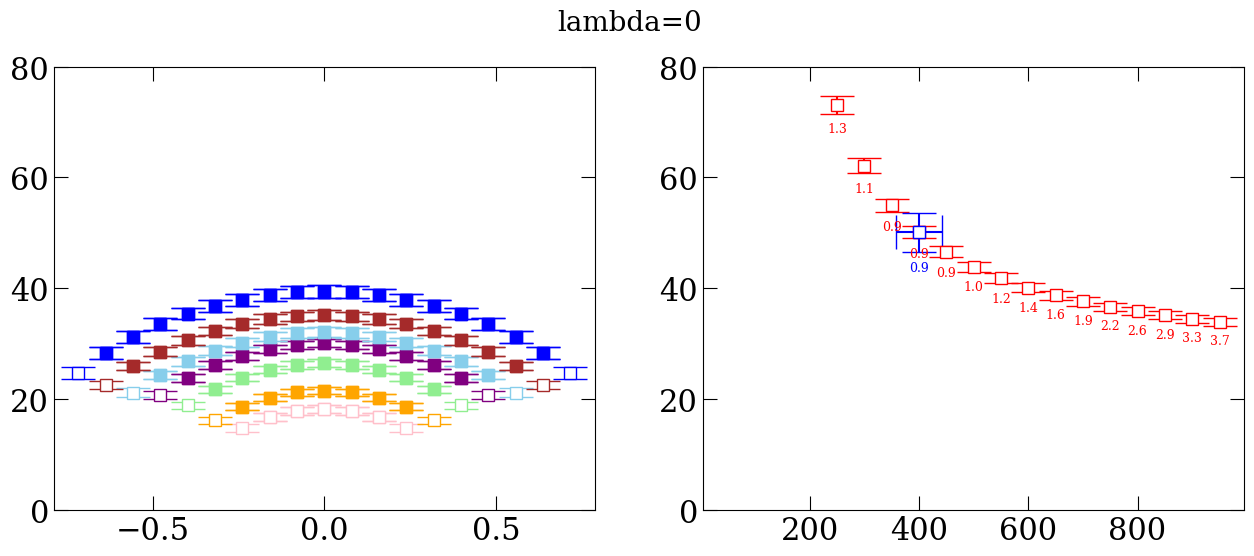

In [24]:
tfmin=10
tcmin=2

chi2Size=9
colorDic={8:'pink',10:'orange',12:'lightgreen',14:'purple',16:'skyblue',18:'brown',20:'blue'}
fmtDic={4:'v',5:'d',6:'o',7:'s',8:'<',9:'>',10:'^'}

ops=['g;0,0,0;G1g;a;l1;p','g;0,0,0;G1g;N0sgm0,a;l1;p,sgm']
j='j+'; tfs=[8,10,12,14,16,18,20]

c2ptM=get2ptMat(ops)
# for tf in c2ptCorrDic_NJN.keys():
#     c2ptM[:,tf,0,0]=c2ptCorrDic_NJN[tf]
c3ptM_dic={tf:get3ptMat(ops,ops,f'id_{j}_{tf}',diags=yu.diags_all) for tf in tfs}

GEVP_t0,GEVP_t=7,14
evals,evecs=yu.GEVP(np.mean(c2ptM,axis=0),GEVP_t0)
Revec=evecs[GEVP_t,0,1]/evecs[GEVP_t,0,0]

lbd=0
x=Revec*lbd
c2pt=np.real(c2ptM[:,:,0,0] + x*c2ptM[:,:,0,1] + x*c2ptM[:,:,1,0] + x**2*c2ptM[:,:,1,1] *0)
c3ptDic={tf:np.real(c3ptM_dic[tf][:,:,0,0]+ x*c3ptM_dic[tf][:,:,0,1] + x*c3ptM_dic[tf][:,:,1,0]) for tf in tfs}
c2ptCorrDic={tf:np.real(c2ptCorrDic_NJN[tf] + x*c2ptM[:,tf,0,1] + x*c2ptM[:,tf,1,0]) for tf in tfs}

ratioCorr={tf:c3ptDic[tf][:,:]/c2ptCorrDic[tf][:,None] for tf in tfs}


tfs_fit=[tf for tf in tfs if tf>=tfmin]
tcs_fit={tf:np.arange(tcmin,tf//2+1) for tf in tfs_fit}
c3pt_fit=np.concatenate([ratioCorr[tf][:,tcs_fit[tf]] for tf in tfs_fit],axis=1)
c_fit=np.concatenate([c3pt_fit],axis=1)

fig, axs = yu.getFigAxs(1,2)
fig.suptitle(f'lambda={lbd}')

ax=axs[0,0]
xunit=ens2a[ens]; yunit=[1,0.4638,ens2amu[ens]*ens2aInv[ens],][2]
ax.set_ylim(settings['ylim'])
for tf in tfs:
    t_cut=1
    ratio=ratioCorr[tf]
    mean,err=yu.jackme(ratio)
    
    if tf%2==0:
        plt_x=np.arange(t_cut - tf//2,tf//2 - (t_cut-1))*xunit; plt_y=mean[t_cut:tf+1-t_cut]*yunit; plt_yerr=err[t_cut:tf+1-t_cut]*yunit
    else:
        plt_x=(np.arange(t_cut - tf//2,tf//2 - (t_cut-1)+1)-0.5)*xunit; plt_y=mean[t_cut:tf+1-t_cut]*yunit; plt_yerr=err[t_cut:tf+1-t_cut]*yunit
    ax.errorbar(plt_x,plt_y,plt_yerr,color=colorDic[tf] if tf in colorDic else None,mfc='white')  
    
    t_cut=tcmin
    if tf%2==0:
        plt_x=np.arange(t_cut - tf//2,tf//2 - (t_cut-1))*xunit; plt_y=mean[t_cut:tf+1-t_cut]*yunit; plt_yerr=err[t_cut:tf+1-t_cut]*yunit
    else:
        plt_x=(np.arange(t_cut - tf//2,tf//2 - (t_cut-1)+1)-0.5)*xunit; plt_y=mean[t_cut:tf+1-t_cut]*yunit; plt_yerr=err[t_cut:tf+1-t_cut]*yunit
    ax.errorbar(plt_x,plt_y,plt_yerr,color=colorDic[tf] if tf in colorDic else None,mfc=None if tf in tfs_fit else 'white')  

ax=axs[0,1]
# ax.set_ylim([0,500])
ax.set_ylim(settings['ylim'])
# ax2=ax.twinx(); ax2.set_ylim([0,2])
# ax2=axs[1,1]
for dE1t_phy in range(50,1000,50):
    print(dE1t_phy,end='                  \r')
    def fitfunc(pars):
        g,ra01,ra11,E0,dE1,rc1=pars
        dE1t=dE1t_phy/ens2aInv[ens]
        t3pt=[func_ratio_2st_noshare(tf,tcs_fit[tf],g,dE1,dE1t,rc1,ra01,ra11) for tf in tfs_fit]
        return np.concatenate(t3pt)
    pars0=[10,-1,1]
    pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,c_fit,pars0,mask=None, parsExtra_jk=temp_parsExtra_jk)
    mean,err=yu.jackme(pars_jk)
    chi2R=np.mean(chi2_jk)/Ndof
    
    m,e=yu.jackme(chi2_jk); 
    print(dE1t_phy,yu.un2str(m[0],e[0]),Ndof,yu.un2str(m[0]/Ndof,e[0]/Ndof))
    
    color='r'
    yunit=ens2amu[ens]*ens2aInv[ens]
    plt_x=dE1t_phy; plt_y=mean[0]*yunit; plt_yerr=err[0]*yunit
    ax.errorbar(plt_x,plt_y,plt_yerr,color=color,mfc='white')
    ylim=ax.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/24
    ax.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_yerr-chi2_shift),color=color,size=chi2Size,ha='center')
    
    # yunit=ens2amu[ens]*ens2aInv[ens]
    # plt_x=dE1t_phy; plt_y=mean[1]*yunit; plt_yerr=err[1]*yunit
    # ax2.errorbar(plt_x,plt_y,plt_yerr,color=color,mfc='white')
    # ylim=ax.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/24
    # ax2.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_yerr-chi2_shift),color=color,size=chi2Size,ha='center')
    # break
    
def fitfunc(pars):
    g,dE1t,ra01,ra11,E0,dE1,rc1=pars
    t3pt=[func_ratio_2st_noshare(tf,tcs_fit[tf],g,dE1,dE1t,rc1,ra01,ra11) for tf in tfs_fit]
    return np.concatenate(t3pt)
pars0=[10,0.5,-1,1]
pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,c_fit,pars0,mask=None, parsExtra_jk=temp_parsExtra_jk)
mean,err=yu.jackme(pars_jk)
chi2R=np.mean(chi2_jk)/Ndof
color='b'
xunit=ens2aInv[ens] ; yunit=ens2amu[ens]*ens2aInv[ens]
plt_x=mean[1]*xunit; plt_xerr=err[1]*xunit; plt_y=mean[0]*yunit; plt_yerr=err[0]*yunit
ax.errorbar(plt_x,plt_y,plt_yerr,xerr=plt_xerr,color=color,mfc='white')
ylim=ax.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/24
ax.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_yerr-chi2_shift),color=color,size=chi2Size,ha='center')
print(yu.un2str(plt_x,plt_xerr),yu.un2str(plt_y,plt_yerr))

None

200 191.01(21) 36 5.3058(58)
300 168.65(21) 36 4.6847(58)
400 148.45(21) 36 4.1236(58)
500 130.50(21) 36 3.6249(58)
600 114.82(21) 36 3.1894(58)
700 101.37(21) 36 2.8159(58)
800 90.08(21) 36 2.5021(57)
900 80.81(21) 36 2.2448(57)
1000 73.42(21) 36 2.0395(57)
1100 67.74(21) 36 1.8817(57)
1200 63.59(21) 36 1.7663(57)
1300 60.78(20) 36 1.6883(57)
1400 59.14(20) 36 1.6429(57)
1500 58.52(20) 36 1.6254(57)
1600 58.74(20) 36 1.6318(57)
1700 59.69(20) 36 1.6580(57)
1800 61.23(20) 36 1.7008(56)
1900 63.26(20) 36 1.7571(56)
1520(130) 42.60(81)


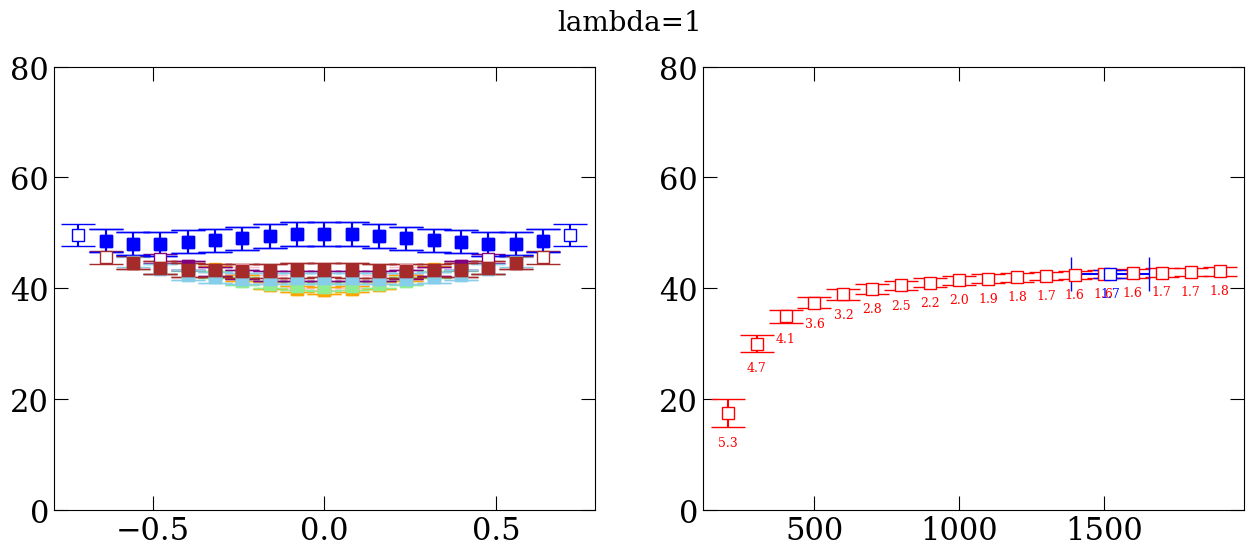

In [28]:
tfmin=10
tcmin=2

chi2Size=9
colorDic={8:'pink',10:'orange',12:'lightgreen',14:'purple',16:'skyblue',18:'brown',20:'blue'}
fmtDic={4:'v',5:'d',6:'o',7:'s',8:'<',9:'>',10:'^'}

ops=['g;0,0,0;G1g;a;l1;p','g;0,0,0;G1g;N0sgm0,a;l1;p,sgm']
j='j+'; tfs=[8,10,12,14,16,18,20]

c2ptM=get2ptMat(ops)
# for tf in c2ptCorrDic_NJN.keys():
#     c2ptM[:,tf,0,0]=c2ptCorrDic_NJN[tf]
c3ptM_dic={tf:get3ptMat(ops,ops,f'id_{j}_{tf}',diags=yu.diags_all) for tf in tfs}

GEVP_t0,GEVP_t=7,14
evals,evecs=yu.GEVP(np.mean(c2ptM,axis=0),GEVP_t0)
Revec=evecs[GEVP_t,0,1]/evecs[GEVP_t,0,0]

lbd=1
x=Revec*lbd
c2pt=np.real(c2ptM[:,:,0,0] + x*c2ptM[:,:,0,1] + x*c2ptM[:,:,1,0] + x**2*c2ptM[:,:,1,1] *0)
c3ptDic={tf:np.real(c3ptM_dic[tf][:,:,0,0]+ x*c3ptM_dic[tf][:,:,0,1] + x*c3ptM_dic[tf][:,:,1,0]) for tf in tfs}
c2ptCorrDic={tf:np.real(c2ptCorrDic_NJN[tf] + x*c2ptM[:,tf,0,1] + x*c2ptM[:,tf,1,0]) for tf in tfs}

ratioCorr={tf:c3ptDic[tf][:,:]/c2ptCorrDic[tf][:,None] for tf in tfs}


tfs_fit=[tf for tf in tfs if tf>=tfmin]
tcs_fit={tf:np.arange(tcmin,tf//2+1) for tf in tfs_fit}
c3pt_fit=np.concatenate([ratioCorr[tf][:,tcs_fit[tf]] for tf in tfs_fit],axis=1)
c_fit=np.concatenate([c3pt_fit],axis=1)

fig, axs = yu.getFigAxs(1,2)
fig.suptitle(f'lambda={lbd}')

ax=axs[0,0]
xunit=ens2a[ens]; yunit=[1,0.4638,ens2amu[ens]*ens2aInv[ens],][2]
ax.set_ylim(settings['ylim'])
for tf in tfs:
    t_cut=1
    ratio=ratioCorr[tf]
    mean,err=yu.jackme(ratio)
    
    if tf%2==0:
        plt_x=np.arange(t_cut - tf//2,tf//2 - (t_cut-1))*xunit; plt_y=mean[t_cut:tf+1-t_cut]*yunit; plt_yerr=err[t_cut:tf+1-t_cut]*yunit
    else:
        plt_x=(np.arange(t_cut - tf//2,tf//2 - (t_cut-1)+1)-0.5)*xunit; plt_y=mean[t_cut:tf+1-t_cut]*yunit; plt_yerr=err[t_cut:tf+1-t_cut]*yunit
    ax.errorbar(plt_x,plt_y,plt_yerr,color=colorDic[tf] if tf in colorDic else None,mfc='white')  
    
    t_cut=tcmin
    if tf%2==0:
        plt_x=np.arange(t_cut - tf//2,tf//2 - (t_cut-1))*xunit; plt_y=mean[t_cut:tf+1-t_cut]*yunit; plt_yerr=err[t_cut:tf+1-t_cut]*yunit
    else:
        plt_x=(np.arange(t_cut - tf//2,tf//2 - (t_cut-1)+1)-0.5)*xunit; plt_y=mean[t_cut:tf+1-t_cut]*yunit; plt_yerr=err[t_cut:tf+1-t_cut]*yunit
    ax.errorbar(plt_x,plt_y,plt_yerr,color=colorDic[tf] if tf in colorDic else None,mfc=None if tf in tfs_fit else 'white')  

ax=axs[0,1]
# ax.set_ylim([0,500])
ax.set_ylim(settings['ylim'])
# ax2=ax.twinx(); ax2.set_ylim([0,2])
# ax2=axs[1,1]
for dE1t_phy in range(200,2000,100):
    print(dE1t_phy,end='                  \r')
    def fitfunc(pars):
        g,ra01,ra11,E0,dE1,rc1=pars
        dE1t=dE1t_phy/ens2aInv[ens]
        t3pt=[func_ratio_2st_noshare(tf,tcs_fit[tf],g,dE1,dE1t,rc1,ra01,ra11) for tf in tfs_fit]
        return np.concatenate(t3pt)
    pars0=[10,-1,1]
    pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,c_fit,pars0,mask=None, parsExtra_jk=temp_parsExtra_jk)
    mean,err=yu.jackme(pars_jk)
    chi2R=np.mean(chi2_jk)/Ndof
    
    m,e=yu.jackme(chi2_jk); 
    print(dE1t_phy,yu.un2str(m[0],e[0]),Ndof,yu.un2str(m[0]/Ndof,e[0]/Ndof))
    
    color='r'
    yunit=ens2amu[ens]*ens2aInv[ens]
    plt_x=dE1t_phy; plt_y=mean[0]*yunit; plt_yerr=err[0]*yunit
    ax.errorbar(plt_x,plt_y,plt_yerr,color=color,mfc='white')
    ylim=ax.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/24
    ax.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_yerr-chi2_shift),color=color,size=chi2Size,ha='center')
    
    # yunit=ens2amu[ens]*ens2aInv[ens]
    # plt_x=dE1t_phy; plt_y=mean[1]*yunit; plt_yerr=err[1]*yunit
    # ax2.errorbar(plt_x,plt_y,plt_yerr,color=color,mfc='white')
    # ylim=ax.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/24
    # ax2.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_yerr-chi2_shift),color=color,size=chi2Size,ha='center')
    # break
    
def fitfunc(pars):
    g,dE1t,ra01,ra11,E0,dE1,rc1=pars
    t3pt=[func_ratio_2st_noshare(tf,tcs_fit[tf],g,dE1,dE1t,rc1,ra01,ra11) for tf in tfs_fit]
    return np.concatenate(t3pt)
pars0=[10,0.5,-1,1]
pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,c_fit,pars0,mask=None, parsExtra_jk=temp_parsExtra_jk)
mean,err=yu.jackme(pars_jk)
chi2R=np.mean(chi2_jk)/Ndof
color='b'
xunit=ens2aInv[ens] ; yunit=ens2amu[ens]*ens2aInv[ens]
plt_x=mean[1]*xunit; plt_xerr=err[1]*xunit; plt_y=mean[0]*yunit; plt_yerr=err[0]*yunit
ax.errorbar(plt_x,plt_y,plt_yerr,xerr=plt_xerr,color=color,mfc='white')
ylim=ax.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/24
ax.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_yerr-chi2_shift),color=color,size=chi2Size,ha='center')
print(yu.un2str(plt_x,plt_xerr),yu.un2str(plt_y,plt_yerr))

None

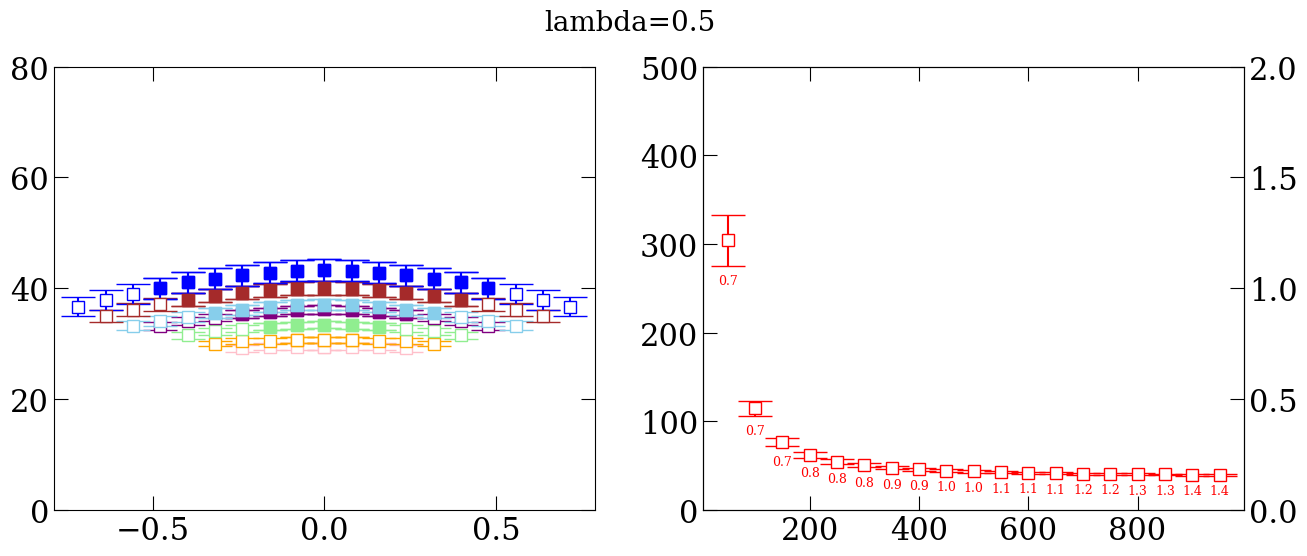

In [ ]:
tfmin=12
tcmin=4

chi2Size=9
colorDic={8:'pink',10:'orange',12:'lightgreen',14:'purple',16:'skyblue',18:'brown',20:'blue'}
fmtDic={4:'v',5:'d',6:'o',7:'s',8:'<',9:'>',10:'^'}

ops=['g;0,0,0;G1g;a;l1;p','g;0,0,0;G1g;N0sgm0,a;l1;p,sgm']
j='j+'; tfs=[8,10,12,14,16,18,20]

c2ptM=get2ptMat(ops)
# for tf in c2ptCorrDic_NJN.keys():
#     c2ptM[:,tf,0,0]=c2ptCorrDic_NJN[tf]
c3ptM_dic={tf:get3ptMat(ops,ops,f'id_{j}_{tf}',diags=yu.diags_all) for tf in tfs}

GEVP_t0,GEVP_t=7,14
evals,evecs=yu.GEVP(np.mean(c2ptM,axis=0),GEVP_t0)
Revec=evecs[GEVP_t,0,1]/evecs[GEVP_t,0,0]

lbd=0.5
x=Revec*lbd
c2pt=np.real(c2ptM[:,:,0,0] + x*c2ptM[:,:,0,1] + x*c2ptM[:,:,1,0] + x**2*c2ptM[:,:,1,1] *0)
c3ptDic={tf:np.real(c3ptM_dic[tf][:,:,0,0]+ x*c3ptM_dic[tf][:,:,0,1] + x*c3ptM_dic[tf][:,:,1,0]) for tf in tfs}
c2ptCorrDic={tf:np.real(c2ptCorrDic_NJN[tf] + x*c2ptM[:,tf,0,1] + x*c2ptM[:,tf,1,0]) for tf in tfs}

ratioCorr={tf:c3ptDic[tf][:,:]/c2ptCorrDic[tf][:,None] for tf in tfs}


tfs_fit=[tf for tf in tfs if tf>=tfmin]
tcs_fit={tf:np.arange(tcmin,tf//2+1) for tf in tfs_fit}
c3pt_fit=np.concatenate([ratioCorr[tf][:,tcs_fit[tf]] for tf in tfs_fit],axis=1)
c_fit=np.concatenate([c3pt_fit],axis=1)

fig, axs = yu.getFigAxs(1,2)
fig.suptitle(f'lambda={lbd}')

ax=axs[0,0]
xunit=ens2a[ens]; yunit=[1,0.4638,ens2amu[ens]*ens2aInv[ens],][2]
ax.set_ylim(settings['ylim'])
for tf in tfs:
    t_cut=1
    ratio=ratioCorr[tf]
    mean,err=yu.jackme(ratio)
    
    if tf%2==0:
        plt_x=np.arange(t_cut - tf//2,tf//2 - (t_cut-1))*xunit; plt_y=mean[t_cut:tf+1-t_cut]*yunit; plt_yerr=err[t_cut:tf+1-t_cut]*yunit
    else:
        plt_x=(np.arange(t_cut - tf//2,tf//2 - (t_cut-1)+1)-0.5)*xunit; plt_y=mean[t_cut:tf+1-t_cut]*yunit; plt_yerr=err[t_cut:tf+1-t_cut]*yunit
    ax.errorbar(plt_x,plt_y,plt_yerr,color=colorDic[tf] if tf in colorDic else None,mfc='white')  
    
    t_cut=tcmin
    if tf%2==0:
        plt_x=np.arange(t_cut - tf//2,tf//2 - (t_cut-1))*xunit; plt_y=mean[t_cut:tf+1-t_cut]*yunit; plt_yerr=err[t_cut:tf+1-t_cut]*yunit
    else:
        plt_x=(np.arange(t_cut - tf//2,tf//2 - (t_cut-1)+1)-0.5)*xunit; plt_y=mean[t_cut:tf+1-t_cut]*yunit; plt_yerr=err[t_cut:tf+1-t_cut]*yunit
    ax.errorbar(plt_x,plt_y,plt_yerr,color=colorDic[tf] if tf in colorDic else None,mfc=None if tf in tfs_fit else 'white')  

ax=axs[0,1]; ax2=ax.twinx()
ax.set_ylim([0,500])
ax2.set_ylim([0,2])
for dE1t_phy in range(50,1000,50):
    print(dE1t_phy,end='                  \r')
    def fitfunc(pars):
        g,ra01,ra11,E0,dE1,rc1=pars
        dE1t=dE1t_phy/ens2aInv[ens]
        t3pt=[func_ratio_2st_noshare(tf,tcs_fit[tf],g,dE1,dE1t,rc1,ra01,ra11) for tf in tfs_fit]
        return np.concatenate(t3pt)
    pars0=[10,-1,1]
    pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,c_fit,pars0,mask=None, parsExtra_jk=temp_parsExtra_jk)
    mean,err=yu.jackme(pars_jk)
    chi2R=np.mean(chi2_jk)/Ndof
    color='r'
    
    yunit=ens2amu[ens]*ens2aInv[ens]
    plt_x=dE1t_phy; plt_y=mean[0]*yunit; plt_yerr=err[0]*yunit
    ax.errorbar(plt_x,plt_y,plt_yerr,color=color,mfc='white')
    ylim=ax.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/24
    ax.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_yerr-chi2_shift),color=color,size=chi2Size,ha='center')
    
    # mean,err=yu.jackme(np.abs(pars_jk))
    # color='g'
    # plt_x=dE1t_phy; plt_y=mean[1]*yunit; plt_yerr=err[1]*yunit
    # ax2.errorbar(plt_x,plt_y,plt_yerr,color=color,mfc='white')
    # color='b'
    # plt_x=dE1t_phy; plt_y=mean[2]*yunit; plt_yerr=err[2]*yunit
    # ax2.errorbar(plt_x,plt_y,plt_yerr,color=color,mfc='white')
    
    # mean,err=yu.jackme(np.sqrt(pars_jk[:,1]**2+pars_jk[:,2]**2))
    # color='purple'
    # plt_x=dE1t_phy; plt_y=mean*yunit; plt_yerr=err*yunit
    # ax2.errorbar(plt_x,plt_y,plt_yerr,color=color,mfc='white')

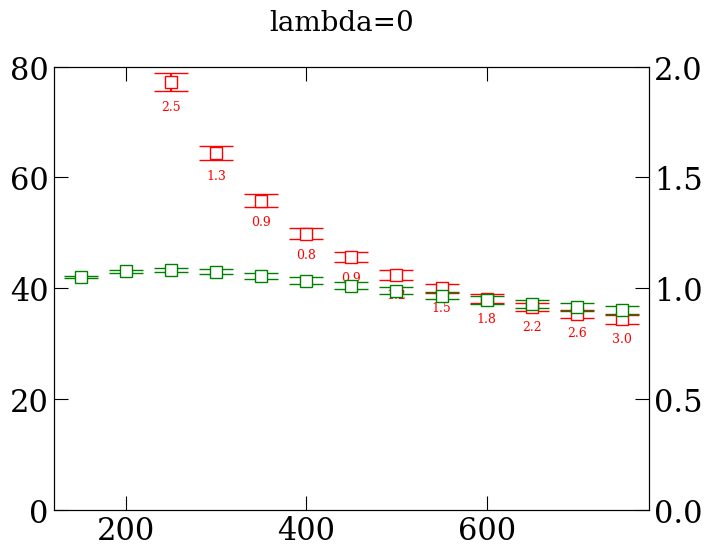

In [72]:
tfmin=10
tcmin=2

chi2Size=9
colorDic={8:'pink',10:'orange',12:'lightgreen',14:'purple',16:'skyblue',18:'brown',20:'blue'}
fmtDic={4:'v',5:'d',6:'o',7:'s',8:'<',9:'>',10:'^'}

ops=['g;0,0,0;G1g;a;l1;p','g;0,0,0;G1g;N0sgm0,a;l1;p,sgm']
j='j+'; tfs=[8,10,12,14,16,18,20]

c2ptM=get2ptMat(ops)
# for tf in c2ptCorrDic_NJN.keys():
#     c2ptM[:,tf,0,0]=c2ptCorrDic_NJN[tf]
c3ptM_dic={tf:get3ptMat(ops,ops,f'id_{j}_{tf}',diags=yu.diags_all) for tf in tfs}

GEVP_t0,GEVP_t=7,14
evals,evecs=yu.GEVP(np.mean(c2ptM,axis=0),GEVP_t0)
Revec=evecs[GEVP_t,0,1]/evecs[GEVP_t,0,0]

lbd=0
x=Revec*lbd
c2pt=np.real(c2ptM[:,:,0,0] + x*c2ptM[:,:,0,1] + x*c2ptM[:,:,1,0] + x**2*c2ptM[:,:,1,1] *0)
c3ptDic={tf:np.real(c3ptM_dic[tf][:,:,0,0]+ x*c3ptM_dic[tf][:,:,0,1] + x*c3ptM_dic[tf][:,:,1,0]) for tf in tfs}
c2ptCorrDic={tf:np.real(c2ptCorrDic_NJN[tf] + x*c2ptM[:,tf,0,1] + x*c2ptM[:,tf,1,0]) for tf in tfs}

ratioCorr={tf:c3ptDic[tf][:,:]/c2ptCorrDic[tf][:,None] for tf in tfs}


tfs_fit=[tf for tf in tfs if tf>=tfmin]
tcs_fit={tf:np.arange(tcmin,tf//2+1) for tf in tfs_fit}
c3pt_fit=np.concatenate([ratioCorr[tf][:,tcs_fit[tf]] for tf in tfs_fit],axis=1)
c_fit=np.concatenate([c3pt_fit],axis=1)

fig, axs = yu.getFigAxs(1,1)
fig.suptitle(f'lambda={lbd}')
ax=axs[0,0]; ax2=ax.twinx()
ax.set_ylim([0,80])
ax2.set_ylim([0,2])
for dE1t_phy in range(150,800,50):
    print(dE1t_phy,end='                  \r')
    def fitfunc(pars):
        g,ra01,E0,dE1,rc1=pars
        dE1t=dE1t_phy/ens2aInv[ens]
        t3pt=[func_ratio_2st_noshare(tf,tcs_fit[tf],g,dE1,dE1t,rc1,ra01,0) for tf in tfs_fit]
        return np.concatenate(t3pt)
    pars0=[10,-1]
    pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,c_fit,pars0,mask=None, parsExtra_jk=temp_parsExtra_jk)
    mean,err=yu.jackme(pars_jk)
    chi2R=np.mean(chi2_jk)/Ndof
    color='r'
    
    yunit=ens2amu[ens]*ens2aInv[ens]
    plt_x=dE1t_phy; plt_y=mean[0]*yunit; plt_yerr=err[0]*yunit
    ax.errorbar(plt_x,plt_y,plt_yerr,color=color,mfc='white')
    ylim=ax.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/24
    ax.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_yerr-chi2_shift),color=color,size=chi2Size,ha='center')
    
    mean,err=yu.jackme(np.abs(pars_jk))
    color='g'
    plt_x=dE1t_phy; plt_y=mean[1]*yunit; plt_yerr=err[1]*yunit
    ax2.errorbar(plt_x,plt_y,plt_yerr,color=color,mfc='white')

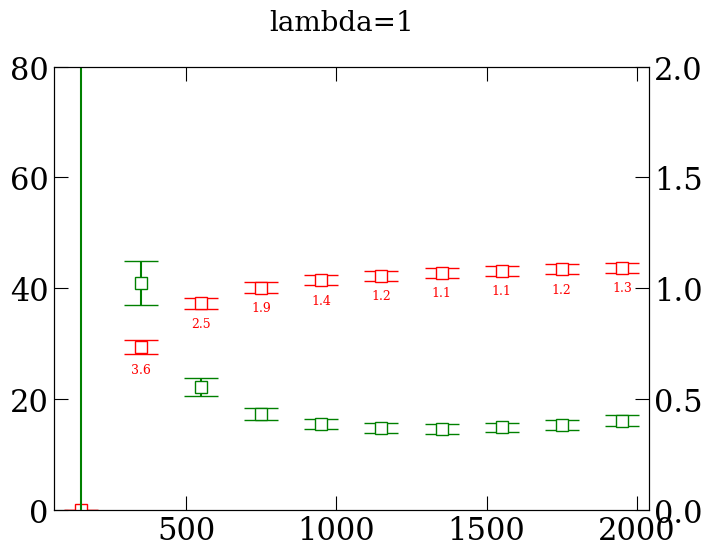

In [67]:
tfmin=10
tcmin=2

chi2Size=9
colorDic={8:'pink',10:'orange',12:'lightgreen',14:'purple',16:'skyblue',18:'brown',20:'blue'}
fmtDic={4:'v',5:'d',6:'o',7:'s',8:'<',9:'>',10:'^'}

ops=['g;0,0,0;G1g;a;l1;p','g;0,0,0;G1g;N0sgm0,a;l1;p,sgm']
j='j+'; tfs=[8,10,12,14,16,18,20]

c2ptM=get2ptMat(ops)
# for tf in c2ptCorrDic_NJN.keys():
#     c2ptM[:,tf,0,0]=c2ptCorrDic_NJN[tf]
c3ptM_dic={tf:get3ptMat(ops,ops,f'id_{j}_{tf}',diags=yu.diags_all) for tf in tfs}

GEVP_t0,GEVP_t=7,14
evals,evecs=yu.GEVP(np.mean(c2ptM,axis=0),GEVP_t0)
Revec=evecs[GEVP_t,0,1]/evecs[GEVP_t,0,0]

lbd=1
x=Revec*lbd
c2pt=np.real(c2ptM[:,:,0,0] + x*c2ptM[:,:,0,1] + x*c2ptM[:,:,1,0] + x**2*c2ptM[:,:,1,1] *0)
c3ptDic={tf:np.real(c3ptM_dic[tf][:,:,0,0]+ x*c3ptM_dic[tf][:,:,0,1] + x*c3ptM_dic[tf][:,:,1,0]) for tf in tfs}
c2ptCorrDic={tf:np.real(c2ptCorrDic_NJN[tf] + x*c2ptM[:,tf,0,1] + x*c2ptM[:,tf,1,0]) for tf in tfs}

ratioCorr={tf:c3ptDic[tf][:,:]/c2ptCorrDic[tf][:,None] for tf in tfs}


tfs_fit=[tf for tf in tfs if tf>=tfmin]
tcs_fit={tf:np.arange(tcmin,tf//2+1) for tf in tfs_fit}
c3pt_fit=np.concatenate([ratioCorr[tf][:,tcs_fit[tf]] for tf in tfs_fit],axis=1)
c_fit=np.concatenate([c3pt_fit],axis=1)

fig, axs = yu.getFigAxs(1,1)
fig.suptitle(f'lambda={lbd}')
ax=axs[0,0]; ax2=ax.twinx()
ax.set_ylim([0,80])
ax2.set_ylim([0,2])
for dE1t_phy in range(150,2000,200):
    print(dE1t_phy,end='                  \r')
    def fitfunc(pars):
        g,ra01,E0,dE1,rc1=pars
        dE1t=dE1t_phy/ens2aInv[ens]
        t3pt=[func_ratio_2st_noshare(tf,tcs_fit[tf],g,dE1,dE1t,rc1,ra01,0) for tf in tfs_fit]
        return np.concatenate(t3pt)
    pars0=[10,-1]
    pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,c_fit,pars0,mask=None, parsExtra_jk=temp_parsExtra_jk)
    mean,err=yu.jackme(pars_jk)
    chi2R=np.mean(chi2_jk)/Ndof
    color='r'
    
    yunit=ens2amu[ens]*ens2aInv[ens]
    plt_x=dE1t_phy; plt_y=mean[0]*yunit; plt_yerr=err[0]*yunit
    ax.errorbar(plt_x,plt_y,plt_yerr,color=color,mfc='white')
    ylim=ax.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/24
    ax.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_yerr-chi2_shift),color=color,size=chi2Size,ha='center')
    
    mean,err=yu.jackme(np.abs(pars_jk))
    color='g'
    plt_x=dE1t_phy; plt_y=mean[1]*yunit; plt_yerr=err[1]*yunit
    ax2.errorbar(plt_x,plt_y,plt_yerr,color=color,mfc='white')

In [20]:
# no share with priors

settings={
    'fitmins_2st':range(1,12+1),
    
    'tmins2pt':[6,7,8,9,10],
    'tfmins':[8,10,12,14,16],
    'tcmins':[1,2,3,4,5,6,7,8],
    
    'tmins2pt':[6,7,8,9,10],
    'tfmins':[10,12,14,16],
    'tcmins':[3,4,5,6,7,8],
    
    # 'tmins2pt':[8],
    # 'tfmins':[12],
    # 'tcmins':[4],
    
    'ylim':[0,80],
}

chi2Size=9
colorDic={8:'pink',10:'orange',12:'lightgreen',14:'purple',16:'skyblue',18:'brown',20:'blue'}
fmtDic={4:'v',5:'d',6:'o',7:'s',8:'<',9:'>',10:'^'}

ops=['g;0,0,0;G1g;a;l1;p','g;0,0,0;G1g;N0sgm0,a;l1;p,sgm']
j='j+'; tfs=[8,10,12,14,16,18,20]

c2ptM=get2ptMat(ops)
# for tf in c2ptCorrDic_NJN.keys():
#     c2ptM[:,tf,0,0]=c2ptCorrDic_NJN[tf]
c3ptM_dic={tf:get3ptMat(ops,ops,f'id_{j}_{tf}',diags=yu.diags_all) for tf in tfs}

GEVP_t0,GEVP_t=7,14
evals,evecs=yu.GEVP(np.mean(c2ptM,axis=0),GEVP_t0)
Revec=evecs[GEVP_t,0,1]/evecs[GEVP_t,0,0]


func_C2pt_1st=lambda t,E0,c0: c0*np.exp(-E0*t)
func_C2pt_2st=lambda t,E0,c0,dE1,rc1: c0*np.exp(-E0*t)*(1 + rc1*np.exp(-dE1*t))
func_C2pt_3st=lambda t,E0,c0,dE1,rc1,dE2,rc2: c0*np.exp(-E0*t)*(1 + rc1*np.exp(-dE1*t) + rc2*np.exp(-dE2*t))
func_mEff_1st=lambda t,E0: np.log(func_C2pt_1st(t,E0,1)/func_C2pt_1st(t+1,E0,1))
func_mEff_2st=lambda t,E0,dE1,rc1: np.log(func_C2pt_2st(t,E0,1,dE1,rc1)/func_C2pt_2st(t+1,E0,1,dE1,rc1))
func_mEff_3st=lambda t,E0,dE1,rc1,dE2,rc2: np.log(func_C2pt_3st(t,E0,1,dE1,rc1,dE2,rc2)/func_C2pt_3st(t+1,E0,1,dE1,rc1,dE2,rc2))

func_C3pt_2st=lambda tf,tc,E0a,E0b,a00,dE1a,dE1b,ra01,ra10,ra11: a00*np.exp(-E0a*(tf-tc))*np.exp(-E0b*tc)*(1 + ra01*np.exp(-dE1b*tc) + ra10*np.exp(-dE1a*(tf-tc)) + ra11*np.exp(-dE1a*(tf-tc))*np.exp(-dE1b*tc)) \
    if a00!=0 else np.exp(-E0a*(tf-tc))*np.exp(-E0b*tc)*(ra01*np.exp(-dE1b*tc) + ra10*np.exp(-dE1a*(tf-tc)) + ra11*np.exp(-dE1a*(tf-tc))*np.exp(-dE1b*tc))
func_ratio_2st=lambda tf,tc,g,dE1,rc1,ra01,ra11:func_C3pt_2st(tf,tc,1,1,g,dE1,dE1,ra01,ra01,ra11)/func_C2pt_2st(tf,1,1,dE1,rc1)
func_ratio_2st_noshare=lambda tf,tc,g,dE1,dE1t,rc1,ra01,ra11:func_C3pt_2st(tf,tc,1,1,g,dE1t,dE1t,ra01,ra01,ra11)/func_C2pt_2st(tf,1,1,dE1,rc1)

def run(lbd,pdf=None):
    fitType=('meff_2step','ratioCorr','corr')
    fitType2pt,fitType3pt,fitTypeCorr=fitType
    
    x=Revec*lbd
    c2pt=np.real(c2ptM[:,:,0,0] + x*c2ptM[:,:,0,1] + x*c2ptM[:,:,1,0] + x**2*c2ptM[:,:,1,1] *0)
    c3ptDic={tf:np.real(c3ptM_dic[tf][:,:,0,0]+ x*c3ptM_dic[tf][:,:,0,1] + x*c3ptM_dic[tf][:,:,1,0]) for tf in tfs}
    c2ptCorrDic={tf:np.real(c2ptCorrDic_NJN[tf] + x*c2ptM[:,tf,0,1] + x*c2ptM[:,tf,1,0]) for tf in tfs}

    ratioCorr={tf:c3ptDic[tf][:,:]/c2ptCorrDic[tf][:,None] for tf in tfs}
    
    C2pt_mean,C2pt_err=yu.jackme(c2pt)
    C2pt_rela=np.abs(C2pt_err/C2pt_mean)
    func=lambda C2pt: np.log(C2pt/np.roll(C2pt,-1,axis=0))
    mEff_jk=yu.jackmap(func,c2pt)
    meff=mEff_jk
    (mEff_mean,mEff_err)=yu.jackme(mEff_jk)
    mEff_rela=np.abs(mEff_err/mEff_mean)
    temp=[(i,rela) for i,rela in enumerate(mEff_rela if fitType2pt=='meff' else C2pt_rela) if rela>0.2 and i!=0]
    tmax2pt=temp[0][0]-1 if len(temp)!=0 else len(C2pt_mean)-2
    
    res2pt=[]
    if fitType2pt in ['meff_2step']:
        pars0_initial=[0.4,0.5,2,0.8,1] if fitType2pt in ['meff_2step'] else [0.4,1e-8,0.5,2,0.8,1]
        pars0=[0.37835373]
        DNpar=1 if fitType2pt in ['meff_2step'] else 0
        color='g'
        fitmins=settings['fitmins_2st']
        pars0=np.hstack([pars0,pars0_initial[2-DNpar:4-DNpar]])
        fits=[]
        for fitmin in fitmins:
            tList=np.arange(fitmin,tmax2pt)
            def fitfunc(pars):
                if fitType2pt in ['meff_2step']:
                    return func_mEff_2st(tList,*pars)
                return func_C2pt_2st(tList,*pars)
            y_jk=mEff_jk[:,tList] if fitType2pt in ['meff_2step'] else c2pt[:,tList]
            
            pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,pars0)
            pars0=np.mean(pars_jk,axis=0)
            # print(fitmin,tmax2pt, pars_jk[0])
            fits.append([fitmin,pars_jk,chi2_jk,Ndof])
        pars_jk,props_jk=yu.jackMA(fits)
        props_mean=np.mean(props_jk,axis=0)
        pars0=yu.jackme(pars_jk)[0]
        res2pt=pars_jk.copy()
    
    parsExtra_jk=res2pt if fitType2pt=='c2pt_2step' else res2pt if fitType2pt=='meff_2step' else None
    pars2pt,pars2pt_err=yu.jackme(parsExtra_jk)
    # priors=[(1,pars2pt[1],pars2pt_err[1]*4)]
    priors=[(1,pars2pt[1],200/ens2aInv[ens])]
    
    pars0_g=np.mean(ratioCorr[tfs[-1]],axis=0)[tfs[-1]//2]
    pars0={'c2pt':[pars0_g,0.4,0.5,0.5,1e-8,1,1,1],'meff':[pars0_g,0.4,0.5,0.5,1,1,1],'c2pt_2step':[pars0_g,0.5,1,1],'meff_2step':[pars0_g,pars2pt[1],-0.3,0]}[fitType2pt]
    # pars0=[27.55791327,  0.10514823, -0.24386032, -0.03973875]
    
    fits=[]
    for i1,tmin2pt in enumerate(settings['tmins2pt']):
        if fitType2pt in ['c2pt_2step','meff_2step'] and i1!=0:
            continue
        for i2,tfmin in enumerate(settings['tfmins']):
            for i3,tcmin in enumerate(settings['tcmins']):
                print(f"{lbd}, {fitType}: ({i1+1}/{len(settings['tmins2pt'])},{i2+1}/{len(settings['tfmins'])},{i3+1}/{len(settings['tcmins'])})",end='                             \r')
                if tfmin+1-tcmin <= tcmin:
                    continue    

                tfs_fit=[tf for tf in tfs if tf>=tfmin]
                tcs_fit={tf:np.arange(tcmin,tf//2+1) for tf in tfs_fit}
                tfs2pt_fit=np.arange(tmin2pt,tmax2pt+1)
                
                c2pt_fit=c2pt[:,tfs2pt_fit] if fitType2pt=='c2pt' else meff[:,tfs2pt_fit] if fitType2pt=='meff' else None
                c3pt_fit=np.concatenate([ \
                    c3ptDic[tf][:,tcs_fit[tf]] if fitType3pt=='c3pt' else
                    ratioCorr[tf][:,tcs_fit[tf]] if fitType3pt=='ratioCorr' else
                    ratio[tf][:,tcs_fit[tf]] \
                        for tf in tfs_fit],axis=1)
                
                c_fit=np.concatenate([c2pt_fit,c3pt_fit],axis=1) if c2pt_fit is not None else np.concatenate([c3pt_fit],axis=1)
                
                def fitfunc(pars):
                    if fitType2pt=='c2pt':
                        g,E0,dE1,dE1t,c0,rc1,ra01,ra11=pars
                        t2pt=func_C2pt_2st(tfs2pt_fit,E0,c0,dE1,rc1)
                    elif fitType2pt=='meff':
                        g,E0,dE1,dE1t,rc1,ra01,ra11=pars
                        t2pt=func_mEff_2st(tfs2pt_fit,E0,dE1,rc1)
                    elif fitType2pt=='c2pt_2step':
                        g,dE1t,ra01,ra11,E0,c0,dE1,rc1=pars
                        t2pt=[]
                    elif fitType2pt=='meff_2step':
                        g,dE1t,ra01,ra11,E0,dE1,rc1=pars
                        dE1t=np.abs(dE1t)
                        t2pt=[]
                    if fitType3pt=='c3pt':
                        t3pt=[func_C3pt_2st(tf,tcs_fit[tf],E0,E0,g*c0,dE1t,dE1t,ra01,ra01,ra11) for tf in tfs_fit]
                    else:
                        t3pt=[func_ratio_2st_noshare(tf,tcs_fit[tf],g,dE1,dE1t,rc1,ra01,ra11) for tf in tfs_fit]
                    t=[t2pt]+t3pt
                    return np.concatenate(t)
                pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,c_fit,pars0,mask=None if fitTypeCorr=='corr' else 'uncorrelated', parsExtra_jk=parsExtra_jk, priors=priors)
                pars_jk[:,1]=np.abs(pars_jk[:,1])
                pars0=np.mean(pars_jk,axis=0)
                fits.append([(tmin2pt,tfmin,tcmin),pars_jk,chi2_jk,Ndof])
                
    fig, axs = yu.getFigAxs(1,2,sharey=True)
    lbd_text='{:.1f}'.format(lbd)
    fig.suptitle(f'lambda={lbd_text}')
    xunit=ens2a[ens]; yunit=[1,0.4638,ens2amu[ens]*ens2aInv[ens],][2]
    ax=axs[0,0]
    ax.set_ylim(settings['ylim'])
    for tf in tfs:
        t_cut=1
        ratio=ratioCorr[tf]
        mean,err=yu.jackme(ratio)
        if tf%2==0:
            plt_x=np.arange(t_cut - tf//2,tf//2 - (t_cut-1))*xunit; plt_y=mean[t_cut:tf+1-t_cut]*yunit; plt_yerr=err[t_cut:tf+1-t_cut]*yunit
        else:
            plt_x=(np.arange(t_cut - tf//2,tf//2 - (t_cut-1)+1)-0.5)*xunit; plt_y=mean[t_cut:tf+1-t_cut]*yunit; plt_yerr=err[t_cut:tf+1-t_cut]*yunit
        ax.errorbar(plt_x,plt_y,plt_yerr,color=colorDic[tf] if tf in colorDic else None,mfc='white')  
        
    ax=axs[0,1]
    color='red'
    pars_jk,props_jk=yu.jackMA(fits)
    ind_mpf=np.argmax(np.mean(props_jk,axis=0))
    # print(fits[ind_mpf][0],np.mean(fits[ind_mpf][2]),fits[ind_mpf][3],np.mean(fits[ind_mpf][2])/fits[ind_mpf][3])
    if fitType2pt in ['c2pt','meff']:
        res=pars_jk.copy()
    elif fitType2pt == 'c2pt_2step':
        res=np.concatenate([pars_jk,parsExtra_jk],axis=1)[:,[0,4,6,1]]
    elif fitType2pt == 'meff_2step':
        res=np.concatenate([pars_jk,parsExtra_jk],axis=1)[:,[0,4,5,1]]
    
    pars_mean,pars_err=yu.jackme(pars_jk)
    # print(pars_mean)
    # print([[m,e] for m,e in zip(pars_mean,pars_err)])
    pars0=pars_mean
    plt_x=np.array([settings['tfmins'][0]-0.5,settings['tfmins'][-1]+0.5])*xunit; plt_y=pars_mean[0]*yunit; plt_err=pars_err[0]*yunit
    ax.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color=color,alpha=0.2, label=r'$\sigma_{\pi N}=$'+yu.un2str(plt_y,plt_err)+f'; MPF:{fits[ind_mpf][0]}')
    for tfmin in settings['tfmins']:
        t_inds=[i for i,fit in enumerate(fits) if fit[0][1]==tfmin]
        t_indind_mpf=np.argmax(np.mean(props_jk,axis=0)[t_inds])
        t_ind_mpf=t_inds[t_indind_mpf]
        fit=fits[t_ind_mpf]
        fitlabel,pars_jk,chi2_jk,Ndof=fit
        (tmin2pt,tfmin,tcmin)=fitlabel
        (pars_mean,pars_err)=yu.jackme(pars_jk)
        chi2R=np.mean(chi2_jk)/Ndof
        
        plt_x=tfmin*xunit; plt_y=pars_mean[0]*yunit; plt_err=pars_err[0]*yunit
        ax.errorbar(plt_x,plt_y,plt_err,fmt=fmtDic[tmin2pt],color=colorDic[tfmin] if tfmin in colorDic else None,mfc='white' if t_ind_mpf==ind_mpf else None)
        ylim=ax.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/12
        ax.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_err-chi2_shift),color=color,size=chi2Size,ha='center')
    
    ax.legend()
        
    plt.tight_layout()
    if pdf!=None:
        pdf.savefig(fig)
    else:
        plt.savefig('fig/fit3pt_withNsgm_noshare.pdf')
    plt.close()
    return res

res3pt={}
import matplotlib.backends.backend_pdf
pdf = matplotlib.backends.backend_pdf.PdfPages("fig/fit3pt_withNsgm_noshare.pdf")
# lbds=[0,0.2,0.6,0.8,1,1.2,1.5]
lbds=[0]+list(np.arange(0.5,1.6,0.1))
lbds=[0.5]
for lbd in lbds:
    res3pt[lbd]=run(lbd,pdf)

fig, axs = yu.getFigAxs(1,2)
yu.addColHeader(axs,[r'$\sigma_{\pi N}$ [MeV]',r'$m_N(red);E_1(green);E_1^{3pt}(blue)$ [GeV]'])
ax1=axs[0,0]
ax2=axs[0,1]
ax1.set_ylim(settings['ylim'])
ax2.set_ylim([0.8,1.8])

for i,lbd in enumerate(lbds):
    pars_jk=res3pt[lbd]
    pars_jk[:,2]+=pars_jk[:,1]
    pars_jk[:,3]+=pars_jk[:,1]
    pars_mean,pars_err=yu.jackme(pars_jk)
    pars0=pars_mean
    
    yunit=[1,0.4638,ens2amu[ens]*ens2aInv[ens],][2]
    plt_x=np.array([lbd]); plt_y=pars_mean[0]*yunit; plt_err=pars_err[0]*yunit
    ax1.errorbar(plt_x,plt_y,plt_err, color='r')
    
    yunit=ens2aInv[ens]/1000
    plt_x=np.array([lbd]); plt_y=pars_mean[1]*yunit; plt_err=pars_err[1]*yunit
    ax2.errorbar(plt_x,plt_y,plt_err, color= 'r')

    plt_x=np.array([lbd]); plt_y=pars_mean[2]*yunit; plt_err=pars_err[2]*yunit
    ax2.errorbar(plt_x,plt_y,plt_err, color='g')

    plt_x=np.array([lbd]); plt_y=pars_mean[3]*yunit; plt_err=pars_err[3]*yunit
    ax2.errorbar(plt_x,plt_y,plt_err, color='b')

plt_x=ax2.get_xlim()
plt_y=(0.9396+0.9383)/2; plt_err=(0.9396-0.9383)/2
ax2.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color='r',alpha=0.2)
# plt_y=(1.47+1.368)/2; plt_err=(1.47-1.368)/2
# ax2.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color='g',alpha=0.2)
# plt_y=1.44; plt_err=0.001
# ax2.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color='g',alpha=0.2)
plt_y=np.sqrt(0.938**2+(2*np.pi/ens2N[ens]*ens2aInv[ens]/1000)**2)+np.sqrt(0.14**2+(2*np.pi/ens2N[ens]*ens2aInv[ens]/1000)**2); plt_err=0.001
ax2.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color='b',alpha=0.2)
# plt_y=0.938+0.14*2; plt_err=0.001
# ax2.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color='purple',alpha=0.2)
# plt_y=0.938+0.5; plt_err=0.001
# ax2.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color='purple',alpha=0.2)

plt.tight_layout()
pdf.savefig(fig)
plt.close()

pdf.close()

In [6]:
# no share

settings={
    # 'tmins2pt':range(8,9+1),
    # 'tfmins':[8,10],
    # 'tcmins':[1,2],
    
    # 'tmins2pt':[4,5,6,7,8,9,10],
    # 'tfmins':[8,10,12,14,16,18],
    # 'tcmins':[1,2,3,4,5,6,7,8,9],
    
    'tmins2pt':[6,7,8,9,10],
    'tfmins':[8,10,12,14,16],
    'tcmins':[1,2,3,4,5,6,7,8],
    
    'tmins2pt':[8],
    'tfmins':[10],
    'tcmins':[2],
    
    'ylim':[0,80],
}

chi2Size=9
colorDic={8:'pink',10:'orange',12:'lightgreen',14:'purple',16:'skyblue',18:'brown',20:'blue'}
fmtDic={4:'v',5:'d',6:'o',7:'s',8:'<',9:'>',10:'^'}

ops=['g;0,0,0;G1g;a;l1;p','g;0,0,0;G1g;N0sgm0,a;l1;p,sgm']
j='j+'; tfs=[8,10,12,14,16,18,20]

c2ptM=get2ptMat(ops)
# for tf in c2ptCorrDic_NJN.keys():
#     c2ptM[:,tf,0,0]=c2ptCorrDic_NJN[tf]
c3ptM_dic={tf:get3ptMat(ops,ops,f'id_{j}_{tf}',diags=yu.diags_all) for tf in tfs}

GEVP_t0,GEVP_t=7,14
evals,evecs=yu.GEVP(np.mean(c2ptM,axis=0),GEVP_t0)
Revec=evecs[GEVP_t,0,1]/evecs[GEVP_t,0,0]


func_C2pt_1st=lambda t,E0,c0: c0*np.exp(-E0*t)
func_C2pt_2st=lambda t,E0,c0,dE1,rc1: c0*np.exp(-E0*t)*(1 + rc1*np.exp(-dE1*t))
func_C2pt_3st=lambda t,E0,c0,dE1,rc1,dE2,rc2: c0*np.exp(-E0*t)*(1 + rc1*np.exp(-dE1*t) + rc2*np.exp(-dE2*t))
func_mEff_1st=lambda t,E0: np.log(func_C2pt_1st(t,E0,1)/func_C2pt_1st(t+1,E0,1))
func_mEff_2st=lambda t,E0,dE1,rc1: np.log(func_C2pt_2st(t,E0,1,dE1,rc1)/func_C2pt_2st(t+1,E0,1,dE1,rc1))
func_mEff_3st=lambda t,E0,dE1,rc1,dE2,rc2: np.log(func_C2pt_3st(t,E0,1,dE1,rc1,dE2,rc2)/func_C2pt_3st(t+1,E0,1,dE1,rc1,dE2,rc2))

func_C3pt_2st=lambda tf,tc,E0a,E0b,a00,dE1a,dE1b,ra01,ra10,ra11: a00*np.exp(-E0a*(tf-tc))*np.exp(-E0b*tc)*(1 + ra01*np.exp(-dE1b*tc) + ra10*np.exp(-dE1a*(tf-tc)) + ra11*np.exp(-dE1a*(tf-tc))*np.exp(-dE1b*tc)) \
    if a00!=0 else np.exp(-E0a*(tf-tc))*np.exp(-E0b*tc)*(ra01*np.exp(-dE1b*tc) + ra10*np.exp(-dE1a*(tf-tc)) + ra11*np.exp(-dE1a*(tf-tc))*np.exp(-dE1b*tc))
func_ratio_2st=lambda tf,tc,g,dE1,rc1,ra01,ra11:func_C3pt_2st(tf,tc,1,1,g,dE1,dE1,ra01,ra01,ra11)/func_C2pt_2st(tf,1,1,dE1,rc1)
func_ratio_2st_noshare=lambda tf,tc,g,dE1,dE1t,rc1,ra01,ra11:func_C3pt_2st(tf,tc,1,1,g,dE1t,dE1t,ra01,ra01,ra11)/func_C2pt_2st(tf,1,1,dE1,rc1)

def run(lbd,pdf=None):
    fitType=('meff','ratioCorr','corr')
    fitType2pt,fitType3pt,fitTypeCorr=fitType
    
    x=Revec*lbd
    c2pt=np.real(c2ptM[:,:,0,0] + x*c2ptM[:,:,0,1] + x*c2ptM[:,:,1,0] + x**2*c2ptM[:,:,1,1] *0)
    c3ptDic={tf:np.real(c3ptM_dic[tf][:,:,0,0]+ x*c3ptM_dic[tf][:,:,0,1] + x*c3ptM_dic[tf][:,:,1,0]) for tf in tfs}
    c2ptCorrDic={tf:np.real(c2ptCorrDic_NJN[tf] + x*c2ptM[:,tf,0,1] + x*c2ptM[:,tf,1,0]) for tf in tfs}

    ratioCorr={tf:c3ptDic[tf][:,:]/c2ptCorrDic[tf][:,None] for tf in tfs}
    
    C2pt_mean,C2pt_err=yu.jackme(c2pt)
    C2pt_rela=np.abs(C2pt_err/C2pt_mean)
    func=lambda C2pt: np.log(C2pt/np.roll(C2pt,-1,axis=0))
    mEff_jk=yu.jackmap(func,c2pt)
    meff=mEff_jk
    (mEff_mean,mEff_err)=yu.jackme(mEff_jk)
    mEff_rela=np.abs(mEff_err/mEff_mean)
    temp=[(i,rela) for i,rela in enumerate(mEff_rela if fitType2pt=='meff' else C2pt_rela) if rela>0.2 and i!=0]
    tmax2pt=temp[0][0]-1 if len(temp)!=0 else len(C2pt_mean)-2
    
    parsExtra_jk=res2pt[(True,False)] if fitType2pt=='c2pt_2step' else res2pt[(True,True)] if fitType2pt=='meff_2step' else None

    pars0={'c2pt':[10,0.4,0.5,0.5,1e-8,1,1,1],'meff':[10,0.4,0.5,0.5,1,1,1],'c2pt_2step':[10,0.5,1,1],'meff_2step':[10,0.5,1,1]}[fitType2pt]
    fits=[]
    for i1,tmin2pt in enumerate(settings['tmins2pt']):
        if fitType2pt in ['c2pt_2step','meff_2step'] and i1!=0:
            continue
        for i2,tfmin in enumerate(settings['tfmins']):
            for i3,tcmin in enumerate(settings['tcmins']):
                print(f"{lbd}, {fitType}: ({i1+1}/{len(settings['tmins2pt'])},{i2+1}/{len(settings['tfmins'])},{i3+1}/{len(settings['tcmins'])})",end='                             \r')
                if tfmin+1-tcmin <= tcmin:
                    continue    

                tfs_fit=[tf for tf in tfs if tf>=tfmin]
                tcs_fit={tf:np.arange(tcmin,tf//2+1) for tf in tfs_fit}
                tfs2pt_fit=np.arange(tmin2pt,tmax2pt+1)
                
                c2pt_fit=c2pt[:,tfs2pt_fit] if fitType2pt=='c2pt' else meff[:,tfs2pt_fit] if fitType2pt=='meff' else None
                c3pt_fit=np.concatenate([ \
                    c3ptDic[tf][:,tcs_fit[tf]] if fitType3pt=='c3pt' else
                    ratioCorr[tf][:,tcs_fit[tf]] if fitType3pt=='ratioCorr' else
                    ratio[tf][:,tcs_fit[tf]] \
                        for tf in tfs_fit],axis=1)
                
                c_fit=np.concatenate([c2pt_fit,c3pt_fit],axis=1) if c2pt_fit is not None else np.concatenate([c3pt_fit],axis=1)
                
                def fitfunc(pars):
                    if fitType2pt=='c2pt':
                        g,E0,dE1,dE1t,c0,rc1,ra01,ra11=pars
                        t2pt=func_C2pt_2st(tfs2pt_fit,E0,c0,dE1,rc1)
                    elif fitType2pt=='meff':
                        g,E0,dE1,dE1t,rc1,ra01,ra11=pars
                        t2pt=func_mEff_2st(tfs2pt_fit,E0,dE1,rc1)
                    elif fitType2pt=='c2pt_2step':
                        g,dE1t,ra01,ra11,E0,c0,dE1,rc1=pars
                        t2pt=[]
                    elif fitType2pt=='meff_2step':
                        g,dE1t,ra01,ra11,E0,dE1,rc1=pars
                        t2pt=[]
                    if fitType3pt=='c3pt':
                        t3pt=[func_C3pt_2st(tf,tcs_fit[tf],E0,E0,g*c0,dE1t,dE1t,ra01,ra01,ra11) for tf in tfs_fit]
                    else:
                        t3pt=[func_ratio_2st_noshare(tf,tcs_fit[tf],g,dE1,dE1t,rc1,ra01,ra11) for tf in tfs_fit]
                    t=[t2pt]+t3pt
                    return np.concatenate(t)
                pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,c_fit,pars0,mask=None if fitTypeCorr=='corr' else 'uncorrelated', parsExtra_jk=parsExtra_jk)
                pars0=np.mean(pars_jk,axis=0)
                fits.append([(tmin2pt,tfmin,tcmin),pars_jk,chi2_jk,Ndof])
                
    fig, axs = yu.getFigAxs(1,2,sharey=True)
    fig.suptitle(f'lambda={lbd}')
    xunit=ens2a[ens]; yunit=[1,0.4638,ens2amu[ens]*ens2aInv[ens],][2]
    ax=axs[0,0]
    ax.set_ylim(settings['ylim'])
    for tf in tfs:
        t_cut=1
        ratio=ratioCorr[tf]
        mean,err=yu.jackme(ratio)
        if tf%2==0:
            plt_x=np.arange(t_cut - tf//2,tf//2 - (t_cut-1))*xunit; plt_y=mean[t_cut:tf+1-t_cut]*yunit; plt_yerr=err[t_cut:tf+1-t_cut]*yunit
        else:
            plt_x=(np.arange(t_cut - tf//2,tf//2 - (t_cut-1)+1)-0.5)*xunit; plt_y=mean[t_cut:tf+1-t_cut]*yunit; plt_yerr=err[t_cut:tf+1-t_cut]*yunit
        ax.errorbar(plt_x,plt_y,plt_yerr,color=colorDic[tf] if tf in colorDic else None,mfc='white')  
        
    ax=axs[0,1]
    color='red'
    pars_jk,props_jk=yu.jackMA(fits)
    ind_mpf=np.argmax(np.mean(props_jk,axis=0))
    # print(fits[ind_mpf][0],np.mean(fits[ind_mpf][2]),fits[ind_mpf][3],np.mean(fits[ind_mpf][2])/fits[ind_mpf][3])
    if fitType2pt in ['c2pt','meff']:
        res=pars_jk.copy()
    elif fitType2pt == 'c2pt_2step':
        res=np.concatenate([pars_jk,parsExtra_jk],axis=1)[:,[0,4,6,1]]
    elif fitType2pt == 'meff_2step':
        res=np.concatenate([pars_jk,parsExtra_jk],axis=1)[:,[0,4,5,1]]
    
    pars_mean,pars_err=yu.jackme(pars_jk)
    pars0=pars_mean
    plt_x=np.array([settings['tfmins'][0]-0.5,settings['tfmins'][-1]+0.5])*xunit; plt_y=pars_mean[0]*yunit; plt_err=pars_err[0]*yunit
    ax.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color=color,alpha=0.2, label=r'$\sigma_{\pi N}=$'+yu.un2str(plt_y,plt_err)+f'; MPF:{fits[ind_mpf][0]}')
    for tfmin in settings['tfmins']:
        t_inds=[i for i,fit in enumerate(fits) if fit[0][1]==tfmin]
        t_indind_mpf=np.argmax(np.mean(props_jk,axis=0)[t_inds])
        t_ind_mpf=t_inds[t_indind_mpf]
        fit=fits[t_ind_mpf]
        fitlabel,pars_jk,chi2_jk,Ndof=fit
        (tmin2pt,tfmin,tcmin)=fitlabel
        (pars_mean,pars_err)=yu.jackme(pars_jk)
        chi2R=np.mean(chi2_jk)/Ndof
        
        plt_x=tfmin*xunit; plt_y=pars_mean[0]*yunit; plt_err=pars_err[0]*yunit
        ax.errorbar(plt_x,plt_y,plt_err,fmt=fmtDic[tmin2pt],color=colorDic[tfmin] if tfmin in colorDic else None,mfc='white' if t_ind_mpf==ind_mpf else None)
        ylim=ax.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/12
        ax.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_err-chi2_shift),color=color,size=chi2Size,ha='center')
    
    ax.legend()
        
    plt.tight_layout()
    if pdf!=None:
        pdf.savefig(fig)
    else:
        plt.savefig('fig/fit3pt_withNsgm_noshare.pdf')
    plt.close()
    return res

res3pt={}
import matplotlib.backends.backend_pdf
pdf = matplotlib.backends.backend_pdf.PdfPages("fig/fit3pt_withNsgm_noshare.pdf")
lbds=[0,0.2,0.6,0.8,1,1.2,1.5]
for lbd in lbds:
    res3pt[lbd]=run(lbd,pdf)

fig, axs = yu.getFigAxs(1,2)
yu.addColHeader(axs,[r'$\sigma_{\pi N}$ [MeV]',r'$m_N(red);E_1(green);E_1^{3pt}(blue)$ [GeV]'])
ax1=axs[0,0]
ax2=axs[0,1]
ax1.set_ylim(settings['ylim'])
ax2.set_ylim([0.8,1.8])

for i,lbd in enumerate(lbds):
    pars_jk=res3pt[lbd]
    pars_jk[:,2]+=pars_jk[:,1]
    pars_jk[:,3]+=pars_jk[:,1]
    pars_mean,pars_err=yu.jackme(pars_jk)
    pars0=pars_mean
    
    yunit=[1,0.4638,ens2amu[ens]*ens2aInv[ens],][2]
    plt_x=np.array([lbd]); plt_y=pars_mean[0]*yunit; plt_err=pars_err[0]*yunit
    ax1.errorbar(plt_x,plt_y,plt_err, color='r')
    
    yunit=ens2aInv[ens]/1000
    plt_x=np.array([lbd]); plt_y=pars_mean[1]*yunit; plt_err=pars_err[1]*yunit
    ax2.errorbar(plt_x,plt_y,plt_err, color= 'r')

    plt_x=np.array([lbd]); plt_y=pars_mean[2]*yunit; plt_err=pars_err[2]*yunit
    ax2.errorbar(plt_x,plt_y,plt_err, color='g')

    plt_x=np.array([lbd]); plt_y=pars_mean[3]*yunit; plt_err=pars_err[3]*yunit
    ax2.errorbar(plt_x,plt_y,plt_err, color='b')

plt_x=ax2.get_xlim()
plt_y=(0.9396+0.9383)/2; plt_err=(0.9396-0.9383)/2
ax2.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color='r',alpha=0.2)
# plt_y=(1.47+1.368)/2; plt_err=(1.47-1.368)/2
# ax2.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color='g',alpha=0.2)
# plt_y=1.44; plt_err=0.001
# ax2.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color='g',alpha=0.2)
plt_y=np.sqrt(0.938**2+(2*np.pi/ens2N[ens]*ens2aInv[ens]/1000)**2)+np.sqrt(0.14**2+(2*np.pi/ens2N[ens]*ens2aInv[ens]/1000)**2); plt_err=0.001
ax2.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color='b',alpha=0.2)
# plt_y=0.938+0.14*2; plt_err=0.001
# ax2.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color='purple',alpha=0.2)
# plt_y=0.938+0.5; plt_err=0.001
# ax2.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color='purple',alpha=0.2)

plt.tight_layout()
pdf.savefig(fig)
plt.close()

pdf.close()

/capstor/store/cscs/userlab/s1174/lyan/code/glwc2/project2/01_Nsgm/util.py:116: RuntimeWarning: Number of calls to function has reached maxfev = 1600.
  pars=leastsq(fitfunc_wrapper2,pars_mean)[0]
